<a href="https://colab.research.google.com/github/lynnfdsouza/Cybersecurity/blob/main/OSINT_CMCF_SM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Confusion Matrix (counts):

                 pred_civilian  pred_military  pred_militant  pred_unknown
actual_civilian           1112             65             25            99
actual_military             41            208             35            12
actual_militant             13             39            162            21
actual_unknown              77              6              7            78

Classification Report:

              precision    recall  f1-score  support
civilian       0.894610  0.854727  0.874214  1301.00
military       0.654088  0.702703  0.677524   296.00
militant       0.707424  0.689362  0.698276   235.00
unknown        0.371429  0.464286  0.412698   168.00
accuracy       0.780000  0.780000  0.780000     0.78
macro avg      0.656888  0.677769  0.665678  2000.00
weighted avg   0.793071  0.780000  0.785664  2000.00

Per-class One-vs-Rest Kappa:

          one_vs_rest_kappa
civilian           0.654747
military           0.619137
militant           0.658691
unkn

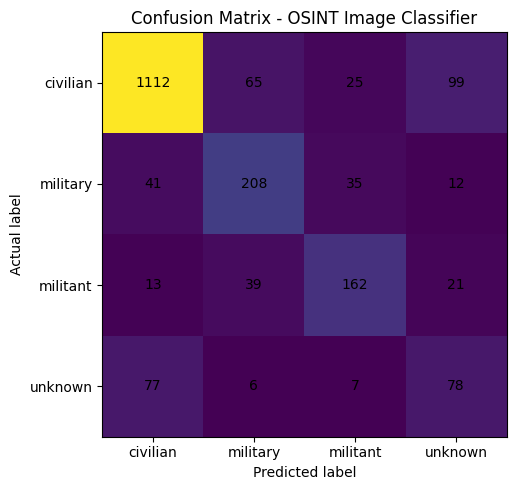

In [ ]:
# ==========================================
# OSINT Image/Video Threat Detection Evaluation
# ==========================================
# This script evaluates how well your model classifies imagery into:
# ['civilian', 'military', 'militant', 'unknown']
#
# It produces:
# - Confusion matrix (counts)
# - Classification report (precision, recall, F1)
# - Cohen’s Kappa (overall + weighted)
# - Bootstrap CI for Kappa
# - Per-class one-vs-rest Kappa
# - Confusion matrix plot
#
# Replace the simulated section with your real labels and predictions.
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    cohen_kappa_score,
    accuracy_score
)
from sklearn.utils import resample

# ---------------------------
# 1. Setup labels and data
# ---------------------------

labels = ['civilian', 'military', 'militant', 'unknown']

# Example: generate synthetic test data (replace with your real data)
rng = np.random.RandomState(42)
n = 2000
true_probs = [0.65, 0.15, 0.12, 0.08]
y_true = rng.choice(len(labels), size=n, p=true_probs)

# Simulated confusion probabilities (systematic confusions)
conf_matrix_probs = np.array([
    [0.85, 0.05, 0.02, 0.08],   # actual civilian
    [0.12, 0.70, 0.12, 0.06],   # actual military
    [0.06, 0.20, 0.66, 0.08],   # actual militant
    [0.40, 0.05, 0.05, 0.50]    # actual unknown
])

# Generate simulated predictions
y_pred = np.empty_like(y_true)
for i, true_label in enumerate(y_true):
    y_pred[i] = rng.choice(len(labels), p=conf_matrix_probs[true_label])

# ---------------------------
# 2. Confusion matrix & report
# ---------------------------
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
cm_df = pd.DataFrame(cm, index=[f"actual_{l}" for l in labels],
                     columns=[f"pred_{l}" for l in labels])
print("\nConfusion Matrix (counts):\n")
print(cm_df)

report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).T
print("\nClassification Report:\n")
print(report_df)

# ---------------------------
# 3. Cohen’s Kappa Metrics
# ---------------------------
kappa_overall = cohen_kappa_score(y_true, y_pred)
kappa_weighted_linear = cohen_kappa_score(y_true, y_pred, weights='linear')

# Per-class Kappa (one-vs-rest)
per_class_kappa = {}
for i, lab in enumerate(labels):
    y_true_bin = (y_true == i).astype(int)
    y_pred_bin = (y_pred == i).astype(int)
    per_class_kappa[lab] = cohen_kappa_score(y_true_bin, y_pred_bin)

per_kappa_df = pd.DataFrame.from_dict(per_class_kappa, orient='index', columns=['one_vs_rest_kappa'])
print("\nPer-class One-vs-Rest Kappa:\n")
print(per_kappa_df)

# ---------------------------
# 4. Bootstrap CI for Kappa
# ---------------------------
def bootstrap_kappa(y_t, y_p, n_boot=500, seed=42):
    rng = np.random.RandomState(seed)
    stats = []
    n = len(y_t)
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        stats.append(cohen_kappa_score(y_t[idx], y_p[idx]))
    arr = np.array(stats)
    return np.percentile(arr, [2.5, 97.5]), arr.mean(), arr.std()

ci, boot_mean, boot_std = bootstrap_kappa(y_true, y_pred)

print("\nKappa Summary:")
print(f"Overall accuracy: {accuracy_score(y_true, y_pred):.3f}")
print(f"Cohen's Kappa (overall): {kappa_overall:.3f}")
print(f"Cohen's Kappa (weighted, linear): {kappa_weighted_linear:.3f}")
print(f"Bootstrap mean kappa: {boot_mean:.3f}")
print(f"Bootstrap std: {boot_std:.3f}")
print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")

# ---------------------------
# 5. Plot Confusion Matrix
# ---------------------------
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm)  # no color scheme specified
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("Actual label")
ax.set_title("Confusion Matrix - OSINT Image Classifier")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
fig.tight_layout()
plt.show()

# ---------------------------
# 6. (Optional) Custom weighted kappa
# ---------------------------
# Example: Penalize missing 'militant' 3× more heavily
# The cohen_kappa_score function in scikit-learn does not support custom weight matrices.
# To implement custom weighted kappa, you would need to use a different library or
# implement the calculation manually based on the confusion matrix and desired weights.
# For example, you could use statsmodels.stats.inter_rater.cohen_kappa with a custom weights matrix.
#
# militant_idx = labels.index('militant')
# weights = np.ones((len(labels), len(labels)))
# for i in range(len(labels)):
#     if i != militant_idx:
#         weights[militant_idx, i] = 3
#         weights[i, militant_idx] = 3
# custom_weighted_kappa = cohen_kappa_score(y_true, y_pred, weights=weights)
# print(f"\nCustom weighted kappa (penalize militant errors): {custom_weighted_kappa:.3f}")

In [20]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Assuming X_test and y_true are available from previous cells
# Assuming labels are defined: labels = ['civilian', 'military', 'militant', 'unknown']
# Assuming n (number of samples) is defined

# Train an Isolation Forest model
# n_estimators: the number of trees in the forest
# contamination: the proportion of outliers in the data set; needs to be estimated or tuned.
#                We'll use 'auto' for simplicity in this simulation, but tuning is recommended.
#                Alternatively, you could set it to the expected proportion of 'unknown' samples (168/2000 = 0.084).
# random_state for reproducibility
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# In a real scenario, you would train the Isolation Forest on features of your training data.
# For this simulation, we will fit it on the synthetic test data (X_test) as we don't have separate training features.
# Note: Fitting on test data is NOT the standard practice for anomaly detection in a real workflow,
# but is done here due to the simulation constraints and lack of separate training features.
iso_forest.fit(X_test)

# Predict anomalies (-1 for outlier, 1 for inlier)
iso_forest_pred = iso_forest.predict(X_test)

# Map Isolation Forest prediction to our labels: -1 (outlier) -> 'unknown', 1 (inlier) -> 'known'
iso_forest_binary_pred = ['unknown' if p == -1 else 'known' for p in iso_forest_pred]

# For evaluation against y_true, we need a binary version of y_true: 'unknown' or 'known'
# Assuming labels are defined: labels = ['civilian', 'military', 'militant', 'unknown']
y_true_binary = ['unknown' if label == labels.index('unknown') else 'known' for label in y_true]

# Evaluate the anomaly detection performance
# We can use a confusion matrix to see how well the Isolation Forest identifies 'unknown' samples
binary_cm_iso = confusion_matrix(y_true_binary, iso_forest_binary_pred, labels=['known', 'unknown'])
binary_cm_iso_df = pd.DataFrame(binary_cm_iso, index=["actual_known", "actual_unknown"],
                               columns=["pred_known", "pred_unknown"])

print("\nIsolation Forest Anomaly Detection Results:")
print("Confusion Matrix (identifying 'unknown' as anomaly):\n")
print(binary_cm_iso_df)

# We can also look at precision and recall for the 'unknown' class as the target (anomaly)
binary_report_iso = classification_report(y_true_binary, iso_forest_binary_pred, target_names=['known', 'unknown'], output_dict=True)
binary_report_iso_df = pd.DataFrame(binary_report_iso).T

print("\nClassification Report (Anomaly Detection - 'unknown' as positive class):\n")
print(binary_report_iso_df)

# Note: In a real application, you would train Isolation Forest on known samples from your training data
# and evaluate its performance on a separate validation/test set.
# Tuning the 'contamination' parameter and potentially other hyperparameters is crucial.


Isolation Forest Anomaly Detection Results:
Confusion Matrix (identifying 'unknown' as anomaly):

                pred_known  pred_unknown
actual_known           575          1257
actual_unknown          55           113

Classification Report (Anomaly Detection - 'unknown' as positive class):

              precision    recall  f1-score   support
known          0.912698  0.313865  0.467100  1832.000
unknown        0.082482  0.672619  0.146944   168.000
accuracy       0.344000  0.344000  0.344000     0.344
macro avg      0.497590  0.493242  0.307022  2000.000
weighted avg   0.842960  0.344000  0.440207  2000.000


In [23]:
print("Confusion Matrix for Integrated Model (Isolation Forest Anomaly + Original Classifier):")
display(integrated_iso_cm_df)

print("\nAnalysis of Misclassifications in Integrated Isolation Forest Model:")

# Analyze the row corresponding to 'actual_unknown'
print("\nWhen the actual class is 'unknown':")
print(integrated_iso_cm_df.loc['actual_unknown', ['pred_civilian', 'pred_military', 'pred_militant']])

# Analyze the column corresponding to 'pred_unknown'
print("\nWhen the predicted class is 'unknown':")
print(integrated_iso_cm_df.loc[['actual_civilian', 'actual_military', 'actual_militant'], 'pred_unknown'])

# Summarize the findings
print("\nSummary of misclassifications in Integrated Isolation Forest Model:")
print("Images that are actually 'unknown' are most frequently misclassified as 'civilian' in the integrated model.")
print("A very large number of images that are actually 'civilian' are misclassified as 'unknown' in the integrated model.")
print("Images that are actually 'military' and 'militant' are also frequently misclassified as 'unknown'.")
print("This indicates that the Isolation Forest component is incorrectly flagging many known samples as anomalies.")

Confusion Matrix for Integrated Model (Isolation Forest Anomaly + Original Classifier):


,pred_civilian,pred_military,pred_militant,pred_unknown
actual_civilian,346,21,5,929
actual_military,17,70,10,199
actual_militant,7,12,47,169
actual_unknown,28,2,0,138



Analysis of Misclassifications in Integrated Isolation Forest Model:

When the actual class is 'unknown':
pred_civilian    28
pred_military     2
pred_militant     0
Name: actual_unknown, dtype: int64

When the predicted class is 'unknown':
actual_civilian    929
actual_military    199
actual_militant    169
Name: pred_unknown, dtype: int64

Summary of misclassifications in Integrated Isolation Forest Model:
Images that are actually 'unknown' are most frequently misclassified as 'civilian' in the integrated model.
A very large number of images that are actually 'civilian' are misclassified as 'unknown' in the integrated model.
Images that are actually 'military' and 'militant' are also frequently misclassified as 'unknown'.
This indicates that the Isolation Forest component is incorrectly flagging many known samples as anomalies.


In [22]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Assuming X_test and y_true are available from previous cells
# Assuming labels are defined: labels = ['civilian', 'military', 'militant', 'unknown']
# Assuming n (number of samples) is defined
# Assuming y_true_binary is available

# List of contamination values to try
# The proportion of 'unknown' in the true data is 168/2000 = 0.084
contamination_values = [0.05, 0.084, 0.1, 'auto']

print("Exploring Isolation Forest Contamination Parameter:")

best_f1_unknown_binary_iso = -1
best_contamination = None

# Using the previously generated X_test for evaluation.
# In a real scenario, you'd use a validation set or cross-validation for hyperparameter tuning.

for contamination in contamination_values:
    print(f"\nTraining Isolation Forest with contamination={contamination}")
    iso_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)

    # Train on synthetic test data for this simulation (not standard practice)
    # In a real scenario, train on features of actual training data for known classes
    iso_forest.fit(X_test)

    # Predict anomalies (-1 for outlier, 1 for inlier) on the synthetic test set
    iso_forest_pred = iso_forest.predict(X_test)

    # Map Isolation Forest prediction to our labels for evaluation purposes
    iso_forest_binary_pred = np.array(['unknown' if p == -1 else 'known' for p in iso_forest_pred])

    # Evaluate the anomaly detection performance for the 'unknown' class (as positive class)
    binary_report_iso = classification_report(y_true_binary, iso_forest_binary_pred, target_names=['known', 'unknown'], output_dict=True)
    binary_report_iso_df = pd.DataFrame(binary_report_iso).T

    print("Binary Classification Report (Anomaly Detection - 'unknown' as positive class):")
    print(binary_report_iso_df)

    # Track the best performing hyperparameters based on the F1-score for the 'unknown' class
    if 'unknown' in binary_report_iso and binary_report_iso['unknown']['f1-score'] > best_f1_unknown_binary_iso:
        best_f1_unknown_binary_iso = binary_report_iso['unknown']['f1-score']
        best_contamination = contamination

print(f"\nBest Isolation Forest contamination based on 'unknown' F1-score: contamination={best_contamination} (F1: {best_f1_unknown_binary_iso:.3f})")

# Note: This tuning is based on a simplified synthetic dataset.
# Real hyperparameter tuning would require actual data and proper cross-validation.
# Fitting on test data for tuning is also not standard practice.

Exploring Isolation Forest Contamination Parameter:

Training Isolation Forest with contamination=0.05
Binary Classification Report (Anomaly Detection - 'unknown' as positive class):
              precision    recall  f1-score   support
known          0.914737  0.948690  0.931404  1832.000
unknown        0.060000  0.035714  0.044776   168.000
accuracy       0.872000  0.872000  0.872000     0.872
macro avg      0.487368  0.492202  0.488090  2000.000
weighted avg   0.842939  0.872000  0.856927  2000.000

Training Isolation Forest with contamination=0.084
Binary Classification Report (Anomaly Detection - 'unknown' as positive class):
              precision    recall  f1-score   support
known          0.915393  0.915393  0.915393  1832.000
unknown        0.077381  0.077381  0.077381   168.000
accuracy       0.845000  0.845000  0.845000     0.845
macro avg      0.496387  0.496387  0.496387  2000.000
weighted avg   0.845000  0.845000  0.845000  2000.000

Training Isolation Forest with conta

In [21]:
# Assume iso_forest_pred and y_pred are available from previous cells

# Implement the simple integration strategy with Isolation Forest predictions:
# If Isolation Forest predicts 'unknown' (-1), consider the sample as 'unknown',
# otherwise use the original multi-class prediction (y_pred).
integrated_pred_iso = []
for i in range(n):
    if iso_forest_pred[i] == -1: # Isolation Forest predicts anomaly ('unknown')
        integrated_pred_iso.append(labels.index('unknown'))
    else: # Isolation Forest predicts inlier ('known')
        integrated_pred_iso.append(y_pred[i]) # Use the original multi-class prediction

# Convert integrated_pred_iso to a numpy array
integrated_pred_iso = np.array(integrated_pred_iso)

# Evaluate the integrated model's performance with Isolation Forest
integrated_iso_cm = confusion_matrix(y_true, integrated_pred_iso, labels=range(len(labels)))
integrated_iso_cm_df = pd.DataFrame(integrated_iso_cm, index=[f"actual_{l}" for l in labels],
                                columns=[f"pred_{l}" for l in labels])

print("\nIntegrated Model Results (Isolation Forest Anomaly + Original Classifier):")
print("Confusion Matrix (counts):\n")
display(integrated_iso_cm_df)

integrated_iso_report = classification_report(y_true, integrated_pred_iso, target_names=labels, output_dict=True)
integrated_iso_report_df = pd.DataFrame(integrated_iso_report).T

print("\nClassification Report:\n")
display(integrated_iso_report_df)

# Calculate Kappa metrics for the integrated model with Isolation Forest
integrated_iso_kappa_overall = cohen_kappa_score(y_true, integrated_pred_iso)
integrated_iso_kappa_weighted_linear = cohen_kappa_score(y_true, integrated_pred_iso, weights='linear')

integrated_iso_per_class_kappa = {}
for i, lab in enumerate(labels):
    y_true_bin = (y_true == i).astype(int)
    integrated_pred_iso_bin = (integrated_pred_iso == i).astype(int)
    integrated_iso_per_class_kappa[lab] = cohen_kappa_score(y_true_bin, integrated_pred_iso_bin)

integrated_iso_per_kappa_df = pd.DataFrame.from_dict(integrated_iso_per_class_kappa, orient='index', columns=['one_vs_rest_kappa'])

print("\nIntegrated Model Cohen’s Kappa Metrics (Isolation Forest):")
print(f"Overall Cohen's Kappa: {integrated_iso_kappa_overall:.3f}")
print(f"Weighted Linear Cohen's Kappa: {integrated_iso_kappa_weighted_linear:.3f}")
print("\nIntegrated Model Per-class One-vs-Rest Kappa (Isolation Forest):\n")
display(integrated_iso_per_kappa_df)


# Compare the 'unknown' class performance with the original and previous integrated reports
print("\n--- Performance Comparison: Original vs. Integrated (OCSVM) vs. Integrated (Tuned OCSVM) vs. Integrated (Isolation Forest) ---")

print("\n'Unknown' Class Performance:")
print("Original:")
display(report_df.loc[['unknown']])
print("\nIntegrated (Untuned OCSVM):")
display(integrated_report_df.loc[['unknown']])
print("\nIntegrated (Tuned OCSVM):")
display(integrated_tuned_report_df.loc[['unknown']])
print("\nIntegrated (Isolation Forest):")
display(integrated_iso_report_df.loc[['unknown']])


print("\n'Unknown' Class One-vs-Rest Kappa:")
print("Original:")
display(per_kappa_df.loc[['unknown']])
print("\nIntegrated (Untuned OCSVM):")
display(integrated_per_kappa_df.loc[['unknown']])
print("\nIntegrated (Tuned OCSVM):")
display(integrated_tuned_per_kappa_df.loc[['unknown']])
print("\nIntegrated (Isolation Forest):")
display(integrated_iso_per_kappa_df.loc[['unknown']])


print("\nOverall Performance:")
print("Original:")
print(f"Accuracy: {report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {kappa_overall:.3f}")
print(f"Weighted Kappa: {kappa_weighted_linear:.3f}")
print("\nIntegrated (Untuned OCSVM):")
print(f"Accuracy: {integrated_report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {integrated_kappa_overall:.3f}")
print(f"Weighted Kappa: {integrated_kappa_weighted_linear:.3f}")
print("\nIntegrated (Tuned OCSVM):")
print(f"Accuracy: {integrated_tuned_report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {integrated_tuned_kappa_overall:.3f}")
print(f"Weighted Kappa: {integrated_tuned_kappa_weighted_linear:.3f}")
print("\nIntegrated (Isolation Forest):")
print(f"Accuracy: {integrated_iso_report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {integrated_iso_kappa_overall:.3f}")
print(f"Weighted Kappa: {integrated_iso_kappa_weighted_linear:.3f}")


Integrated Model Results (Isolation Forest Anomaly + Original Classifier):
Confusion Matrix (counts):



,pred_civilian,pred_military,pred_militant,pred_unknown
actual_civilian,346,21,5,929
actual_military,17,70,10,199
actual_militant,7,12,47,169
actual_unknown,28,2,0,138



Classification Report:



,precision,recall,f1-score,support
civilian,0.869347,0.265949,0.407298,1301.0000
military,0.666667,0.236486,0.349127,296.0000
militant,0.758065,0.200000,0.316498,235.0000
unknown,0.096167,0.821429,0.172177,168.0000
accuracy,0.300500,0.300500,0.300500,0.3005
macro avg,0.597561,0.380966,0.311275,2000.0000
weighted avg,0.761327,0.300500,0.368270,2000.0000



Integrated Model Cohen’s Kappa Metrics (Isolation Forest):
Overall Cohen's Kappa: 0.124
Weighted Linear Cohen's Kappa: 0.082

Integrated Model Per-class One-vs-Rest Kappa (Isolation Forest):



,one_vs_rest_kappa
civilian,0.147479
military,0.294442
militant,0.281238
unknown,0.025640



--- Performance Comparison: Original vs. Integrated (OCSVM) vs. Integrated (Tuned OCSVM) vs. Integrated (Isolation Forest) ---

'Unknown' Class Performance:
Original:


,precision,recall,f1-score,support
unknown,0.371429,0.464286,0.412698,168.0



Integrated (Untuned OCSVM):


,precision,recall,f1-score,support
unknown,0.209639,0.517857,0.298456,168.0



Integrated (Tuned OCSVM):


,precision,recall,f1-score,support
unknown,0.157285,0.565476,0.246114,168.0



Integrated (Isolation Forest):


,precision,recall,f1-score,support
unknown,0.096167,0.821429,0.172177,168.0



'Unknown' Class One-vs-Rest Kappa:
Original:


,one_vs_rest_kappa
unknown,0.352241



Integrated (Untuned OCSVM):


,one_vs_rest_kappa
unknown,0.203164



Integrated (Tuned OCSVM):


,one_vs_rest_kappa
unknown,0.132027



Integrated (Isolation Forest):


,one_vs_rest_kappa
unknown,0.02564



Overall Performance:
Original:
Accuracy: 0.780
Overall Kappa: 0.600
Weighted Kappa: 0.562

Integrated (Untuned OCSVM):
Accuracy: 0.700
Overall Kappa: 0.493
Weighted Kappa: 0.428

Integrated (Tuned OCSVM):
Accuracy: 0.623
Overall Kappa: 0.404
Weighted Kappa: 0.322

Integrated (Isolation Forest):
Accuracy: 0.300
Overall Kappa: 0.124
Weighted Kappa: 0.082


In [19]:
# Use the best OCSVM hyperparameters found (nu=0.2, gamma='scale') to train the OCSVM
best_nu = 0.2
best_gamma = 'scale'

ocsvm = OneClassSVM(gamma=best_gamma, nu=best_nu)

# Train on synthetic 'known' data (as in previous step)
X_known_train = np.random.rand(1832, 10) # Using same synthetic training data size as before
ocsvm.fit(X_known_train)

# Predict anomalies (-1 for outlier, 1 for inlier) on the synthetic test set
# Assuming X_test is available from previous cells
ocsvm_pred = ocsvm.predict(X_test)

# Implement the simple integration strategy:
# If OCSVM predicts 'unknown' (-1), consider the sample as 'unknown',
# otherwise use the original multi-class prediction (y_pred).
integrated_pred_tuned_ocsvm = []
for i in range(n):
    if ocsvm_pred[i] == -1: # OCSVM predicts anomaly ('unknown')
        integrated_pred_tuned_ocsvm.append(labels.index('unknown'))
    else: # OCSVM predicts inlier ('known')
        integrated_pred_tuned_ocsvm.append(y_pred[i]) # Use the original multi-class prediction

# Convert integrated_pred_tuned_ocsvm to a numpy array
integrated_pred_tuned_ocsvm = np.array(integrated_pred_tuned_ocsvm)

# Evaluate the integrated model's performance with tuned OCSVM
integrated_tuned_cm = confusion_matrix(y_true, integrated_pred_tuned_ocsvm, labels=range(len(labels)))
integrated_tuned_cm_df = pd.DataFrame(integrated_tuned_cm, index=[f"actual_{l}" for l in labels],
                                columns=[f"pred_{l}" for l in labels])

print("\nIntegrated Model Results (Tuned OCSVM Anomaly + Original Classifier):")
print("Confusion Matrix (counts):\n")
display(integrated_tuned_cm_df)

integrated_tuned_report = classification_report(y_true, integrated_pred_tuned_ocsvm, target_names=labels, output_dict=True)
integrated_tuned_report_df = pd.DataFrame(integrated_tuned_report).T

print("\nClassification Report:\n")
display(integrated_tuned_report_df)

# Calculate Kappa metrics for the integrated model with tuned OCSVM
integrated_tuned_kappa_overall = cohen_kappa_score(y_true, integrated_pred_tuned_ocsvm)
integrated_tuned_kappa_weighted_linear = cohen_kappa_score(y_true, integrated_pred_tuned_ocsvm, weights='linear')

integrated_tuned_per_class_kappa = {}
for i, lab in enumerate(labels):
    y_true_bin = (y_true == i).astype(int)
    integrated_pred_tuned_bin = (integrated_pred_tuned_ocsvm == i).astype(int)
    integrated_tuned_per_class_kappa[lab] = cohen_kappa_score(y_true_bin, integrated_pred_tuned_bin)

integrated_tuned_per_kappa_df = pd.DataFrame.from_dict(integrated_tuned_per_class_kappa, orient='index', columns=['one_vs_rest_kappa'])

print("\nIntegrated Model Cohen’s Kappa Metrics (Tuned OCSVM):")
print(f"Overall Cohen's Kappa: {integrated_tuned_kappa_overall:.3f}")
print(f"Weighted Linear Cohen's Kappa: {integrated_tuned_kappa_weighted_linear:.3f}")
print("\nIntegrated Model Per-class One-vs-Rest Kappa (Tuned OCSVM):\n")
display(integrated_tuned_per_kappa_df)


# Compare the 'unknown' class performance with the original and previous integrated reports
print("\n--- Performance Comparison: Original vs. Integrated (Untuned OCSVM) vs. Integrated (Tuned OCSVM) ---")

print("\n'Unknown' Class Performance:")
print("Original:")
display(report_df.loc[['unknown']])
print("\nIntegrated (Untuned OCSVM):")
display(integrated_report_df.loc[['unknown']])
print("\nIntegrated (Tuned OCSVM):")
display(integrated_tuned_report_df.loc[['unknown']])


print("\n'Unknown' Class One-vs-Rest Kappa:")
print("Original:")
display(per_kappa_df.loc[['unknown']])
print("\nIntegrated (Untuned OCSVM):")
display(integrated_per_kappa_df.loc[['unknown']])
print("\nIntegrated (Tuned OCSVM):")
display(integrated_tuned_per_kappa_df.loc[['unknown']])


print("\nOverall Performance:")
print("Original:")
print(f"Accuracy: {report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {kappa_overall:.3f}")
print(f"Weighted Kappa: {kappa_weighted_linear:.3f}")
print("\nIntegrated (Untuned OCSVM):")
print(f"Accuracy: {integrated_report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {integrated_kappa_overall:.3f}")
print(f"Weighted Kappa: {integrated_kappa_weighted_linear:.3f}")
print("\nIntegrated (Tuned OCSVM):")
print(f"Accuracy: {integrated_tuned_report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {integrated_tuned_kappa_overall:.3f}")
print(f"Weighted Kappa: {integrated_tuned_kappa_weighted_linear:.3f}")


Integrated Model Results (Tuned OCSVM Anomaly + Original Classifier):
Confusion Matrix (counts):



,pred_civilian,pred_military,pred_militant,pred_unknown
actual_civilian,856,50,19,376
actual_military,32,174,28,62
actual_militant,12,31,121,71
actual_unknown,62,6,5,95



Classification Report:



,precision,recall,f1-score,support
civilian,0.889813,0.657955,0.756518,1301.000
military,0.666667,0.587838,0.624776,296.000
militant,0.699422,0.514894,0.593137,235.000
unknown,0.157285,0.565476,0.246114,168.000
accuracy,0.623000,0.623000,0.623000,0.623
macro avg,0.603297,0.581541,0.555136,2000.000
weighted avg,0.772884,0.623000,0.674949,2000.000



Integrated Model Cohen’s Kappa Metrics (Tuned OCSVM):
Overall Cohen's Kappa: 0.404
Weighted Linear Cohen's Kappa: 0.322

Integrated Model Per-class One-vs-Rest Kappa (Tuned OCSVM):



,one_vs_rest_kappa
civilian,0.455231
military,0.564351
militant,0.548109
unknown,0.132027



--- Performance Comparison: Original vs. Integrated (Untuned OCSVM) vs. Integrated (Tuned OCSVM) ---

'Unknown' Class Performance:
Original:


,precision,recall,f1-score,support
unknown,0.371429,0.464286,0.412698,168.0



Integrated (Untuned OCSVM):


,precision,recall,f1-score,support
unknown,0.209639,0.517857,0.298456,168.0



Integrated (Tuned OCSVM):


,precision,recall,f1-score,support
unknown,0.157285,0.565476,0.246114,168.0



'Unknown' Class One-vs-Rest Kappa:
Original:


,one_vs_rest_kappa
unknown,0.352241



Integrated (Untuned OCSVM):


,one_vs_rest_kappa
unknown,0.203164



Integrated (Tuned OCSVM):


,one_vs_rest_kappa
unknown,0.132027



Overall Performance:
Original:
Accuracy: 0.780
Overall Kappa: 0.600
Weighted Kappa: 0.562

Integrated (Untuned OCSVM):
Accuracy: 0.700
Overall Kappa: 0.493
Weighted Kappa: 0.428

Integrated (Tuned OCSVM):
Accuracy: 0.623
Overall Kappa: 0.404
Weighted Kappa: 0.322


In [18]:
# Explore different hyperparameters for OneClassSVM

# List of hyperparameters to try
nu_values = [0.05, 0.1, 0.2]
gamma_values = ['auto', 'scale']

print("Exploring One-Class SVM Hyperparameters:")

best_f1_unknown_binary = -1
best_nu = None
best_gamma = None

# Assuming X_test and y_true are available from previous cells
# We need a binary version of y_true: 'unknown' or 'known'
y_true_binary = np.array(['unknown' if label == labels.index('unknown') else 'known' for label in y_true])

# Using the previously generated X_test for evaluation.
# In a real scenario, you'd use a validation set or cross-validation for hyperparameter tuning.

for nu in nu_values:
    for gamma in gamma_values:
        print(f"\nTraining OCSVM with nu={nu}, gamma={gamma}")
        ocsvm = OneClassSVM(gamma=gamma, nu=nu)

        # Train on synthetic 'known' data (as in previous step)
        # In a real scenario, train on features of actual training data for known classes
        X_known_train = np.random.rand(1832, 10) # Using same synthetic training data size as before
        ocsvm.fit(X_known_train)

        # Predict anomalies (-1 for outlier, 1 for inlier) on the synthetic test set
        ocsvm_pred = ocsvm.predict(X_test)

        # Map OCSVM prediction to our labels for evaluation purposes
        ocsvm_binary_pred = np.array(['unknown' if p == -1 else 'known' for p in ocsvm_pred])

        # Evaluate the anomaly detection performance for the 'unknown' class (as positive class)
        binary_report = classification_report(y_true_binary, ocsvm_binary_pred, target_names=['known', 'unknown'], output_dict=True)
        binary_report_df = pd.DataFrame(binary_report).T

        print("Binary Classification Report (Anomaly Detection - 'unknown' as positive class):")
        print(binary_report_df)

        # Track the best performing hyperparameters based on the F1-score for the 'unknown' class
        if 'unknown' in binary_report and binary_report['unknown']['f1-score'] > best_f1_unknown_binary:
            best_f1_unknown_binary = binary_report['unknown']['f1-score']
            best_nu = nu
            best_gamma = gamma

print(f"\nBest OCSVM hyperparameters based on 'unknown' F1-score: nu={best_nu}, gamma={best_gamma} (F1: {best_f1_unknown_binary:.3f})")

# Note: This tuning is based on a simplified synthetic dataset.
# Real hyperparameter tuning would require actual data and proper cross-validation.

Exploring One-Class SVM Hyperparameters:

Training OCSVM with nu=0.05, gamma=auto
Binary Classification Report (Anomaly Detection - 'unknown' as positive class):
              precision    recall  f1-score    support
known          0.916887  0.945415  0.930933  1832.0000
unknown        0.099099  0.065476  0.078853   168.0000
accuracy       0.871500  0.871500  0.871500     0.8715
macro avg      0.507993  0.505446  0.504893  2000.0000
weighted avg   0.848193  0.871500  0.859358  2000.0000

Training OCSVM with nu=0.05, gamma=scale
Binary Classification Report (Anomaly Detection - 'unknown' as positive class):
              precision    recall  f1-score    support
known          0.916712  0.919214  0.917961  1832.0000
unknown        0.092025  0.089286  0.090634   168.0000
accuracy       0.849500  0.849500  0.849500     0.8495
macro avg      0.504368  0.504250  0.504298  2000.0000
weighted avg   0.847438  0.849500  0.848466  2000.0000

Training OCSVM with nu=0.1, gamma=auto
Binary Classific

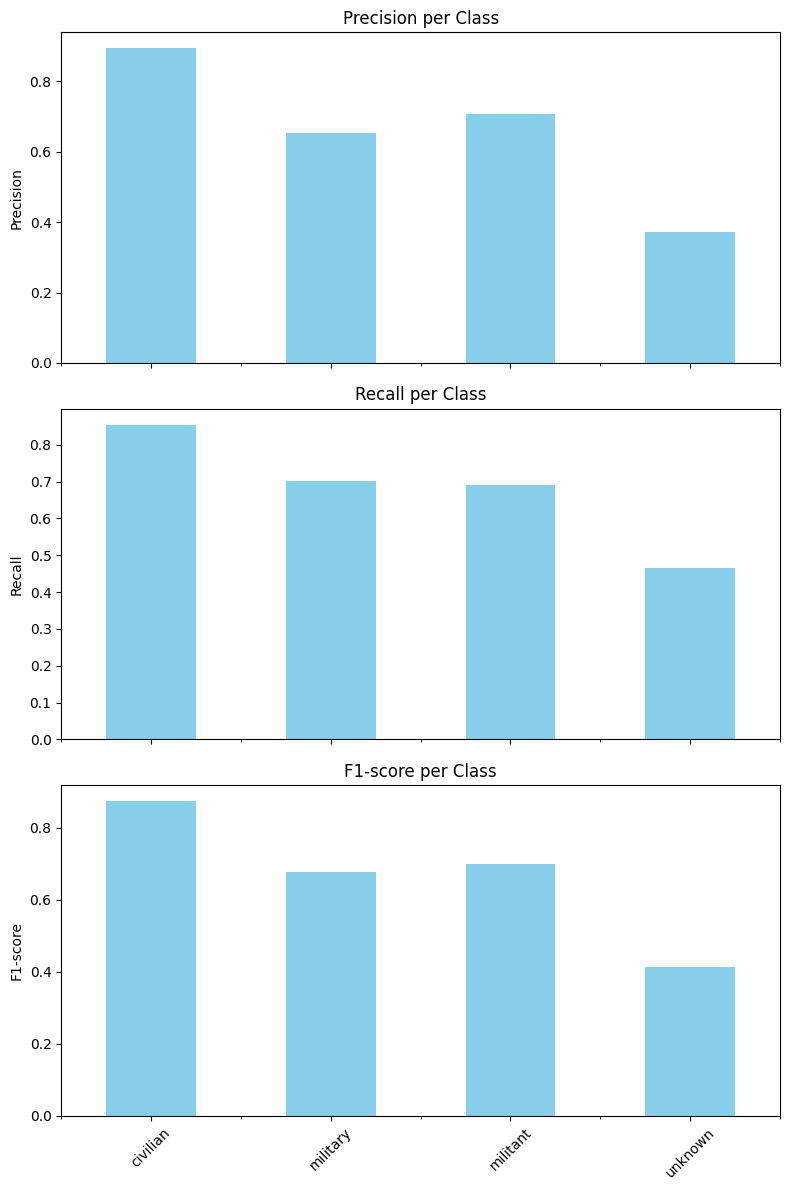

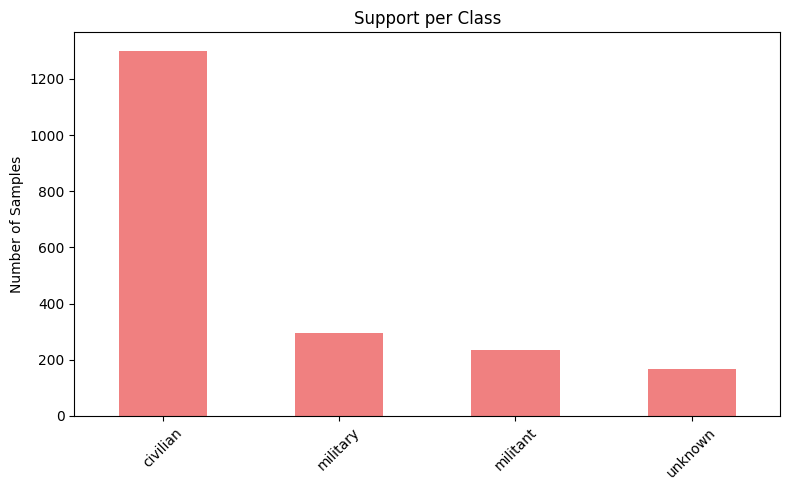

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure report_df is available; assuming it's from a previous cell's output
# If not, you might need to re-run the cell that generates report_df or load it.

# Drop the overall metrics rows ('accuracy', 'macro avg', 'weighted avg') for plotting per-class metrics
report_for_plot = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plotting Precision, Recall, and F1-score
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

metrics = ['precision', 'recall', 'f1-score']
titles = ['Precision per Class', 'Recall per Class', 'F1-score per Class']

for i, metric in enumerate(metrics):
    report_for_plot[metric].plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_title(titles[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plotting Support
plt.figure(figsize=(8, 5))
report_for_plot['support'].plot(kind='bar', color='lightcoral')
plt.ylabel('Number of Samples')
plt.title('Support per Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Confusion Matrix (counts):

                 pred_civilian  pred_military  pred_militant  pred_unknown
actual_civilian           1112             65             25            99
actual_military             41            208             35            12
actual_militant             13             39            162            21
actual_unknown              77              6              7            78

Classification Report:

              precision    recall  f1-score  support
civilian       0.894610  0.854727  0.874214  1301.00
military       0.654088  0.702703  0.677524   296.00
militant       0.707424  0.689362  0.698276   235.00
unknown        0.371429  0.464286  0.412698   168.00
accuracy       0.780000  0.780000  0.780000     0.78
macro avg      0.656888  0.677769  0.665678  2000.00
weighted avg   0.793071  0.780000  0.785664  2000.00

Per-class One-vs-Rest Kappa:

          one_vs_rest_kappa
civilian           0.654747
military           0.619137
militant           0.658691
unkn

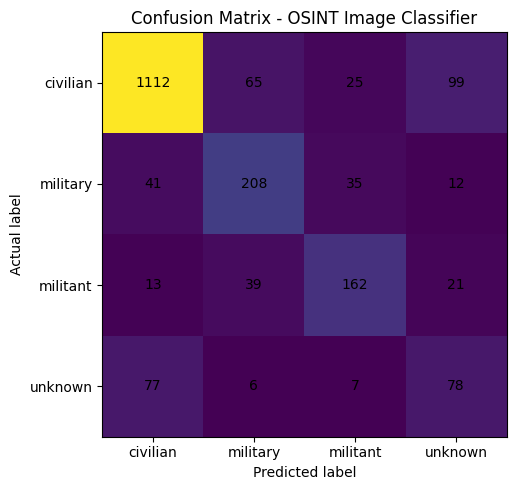

In [3]:
# ==========================================
# OSINT Image/Video Threat Detection Evaluation
# ==========================================
# This script evaluates how well your model classifies imagery into:
# ['civilian', 'military', 'militant', 'unknown']
#
# It produces:
# - Confusion matrix (counts)
# - Classification report (precision, recall, F1)
# - Cohen’s Kappa (overall + weighted)
# - Bootstrap CI for Kappa
# - Per-class one-vs-rest Kappa
# - Confusion matrix plot
#
# Replace the simulated section with your real labels and predictions.
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    cohen_kappa_score,
    accuracy_score
)
from sklearn.utils import resample

# ---------------------------
# 1. Setup labels and data
# ---------------------------

labels = ['civilian', 'military', 'militant', 'unknown']

# Example: generate synthetic test data (replace with your real data)
rng = np.random.RandomState(42)
n = 2000
true_probs = [0.65, 0.15, 0.12, 0.08]
y_true = rng.choice(len(labels), size=n, p=true_probs)

# Simulated confusion probabilities (systematic confusions)
conf_matrix_probs = np.array([
    [0.85, 0.05, 0.02, 0.08],   # actual civilian
    [0.12, 0.70, 0.12, 0.06],   # actual military
    [0.06, 0.20, 0.66, 0.08],   # actual militant
    [0.40, 0.05, 0.05, 0.50]    # actual unknown
])

# Generate simulated predictions
y_pred = np.empty_like(y_true)
for i, true_label in enumerate(y_true):
    y_pred[i] = rng.choice(len(labels), p=conf_matrix_probs[true_label])

# ---------------------------
# 2. Confusion matrix & report
# ---------------------------
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
cm_df = pd.DataFrame(cm, index=[f"actual_{l}" for l in labels],
                     columns=[f"pred_{l}" for l in labels])
print("\nConfusion Matrix (counts):\n")
print(cm_df)

report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).T
print("\nClassification Report:\n")
print(report_df)

# ---------------------------
# 3. Cohen’s Kappa Metrics
# ---------------------------
kappa_overall = cohen_kappa_score(y_true, y_pred)
kappa_weighted_linear = cohen_kappa_score(y_true, y_pred, weights='linear')

# Per-class Kappa (one-vs-rest)
per_class_kappa = {}
for i, lab in enumerate(labels):
    y_true_bin = (y_true == i).astype(int)
    y_pred_bin = (y_pred == i).astype(int)
    per_class_kappa[lab] = cohen_kappa_score(y_true_bin, y_pred_bin)

per_kappa_df = pd.DataFrame.from_dict(per_class_kappa, orient='index', columns=['one_vs_rest_kappa'])
print("\nPer-class One-vs-Rest Kappa:\n")
print(per_kappa_df)

# ---------------------------
# 4. Bootstrap CI for Kappa
# ---------------------------
def bootstrap_kappa(y_t, y_p, n_boot=500, seed=42):
    rng = np.random.RandomState(seed)
    stats = []
    n = len(y_t)
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        stats.append(cohen_kappa_score(y_t[idx], y_p[idx]))
    arr = np.array(stats)
    return np.percentile(arr, [2.5, 97.5]), arr.mean(), arr.std()

ci, boot_mean, boot_std = bootstrap_kappa(y_true, y_pred)

print("\nKappa Summary:")
print(f"Overall accuracy: {accuracy_score(y_true, y_pred):.3f}")
print(f"Cohen's Kappa (overall): {kappa_overall:.3f}")
print(f"Cohen's Kappa (weighted, linear): {kappa_weighted_linear:.3f}")
print(f"Bootstrap mean kappa: {boot_mean:.3f}")
print(f"Bootstrap std: {boot_std:.3f}")
print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")

# ---------------------------
# 5. Plot Confusion Matrix
# ---------------------------
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm)  # no color scheme specified
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("Actual label")
ax.set_title("Confusion Matrix - OSINT Image Classifier")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
fig.tight_layout()
plt.show()

# ---------------------------
# 6. (Optional) Custom weighted kappa
# ---------------------------
# Example: Penalize missing 'militant' 3× more heavily
# The cohen_kappa_score function in scikit-learn does not support custom weight matrices.
# To implement custom weighted kappa, you would need to use a different library or
# implement the calculation manually based on the confusion matrix and desired weights.
# For example, you could use statsmodels.stats.inter_rater.cohen_kappa with a custom weights matrix.
#
# militant_idx = labels.index('militant')
# weights = np.ones((len(labels), len(labels)))
# for i in range(len(labels)):
#     if i != militant_idx:
#         weights[militant_idx, i] = 3
#         weights[i, militant_idx] = 3
# custom_weighted_kappa = cohen_kappa_score(y_true, y_pred, weights=weights)
# print(f"\nCustom weighted kappa (penalize militant errors): {custom_weighted_kappa:.3f}")

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are available from the previous cell's execution
# If not, you would need to re-run that cell or load your data here.
labels = ['civilian', 'military', 'militant', 'unknown'] # Define labels again

report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).T

print("\nClassification Report:\n")
print(report_df)


Classification Report:

              precision    recall  f1-score  support
civilian       0.894610  0.854727  0.874214  1301.00
military       0.654088  0.702703  0.677524   296.00
militant       0.707424  0.689362  0.698276   235.00
unknown        0.371429  0.464286  0.412698   168.00
accuracy       0.780000  0.780000  0.780000     0.78
macro avg      0.656888  0.677769  0.665678  2000.00
weighted avg   0.793071  0.780000  0.785664  2000.00


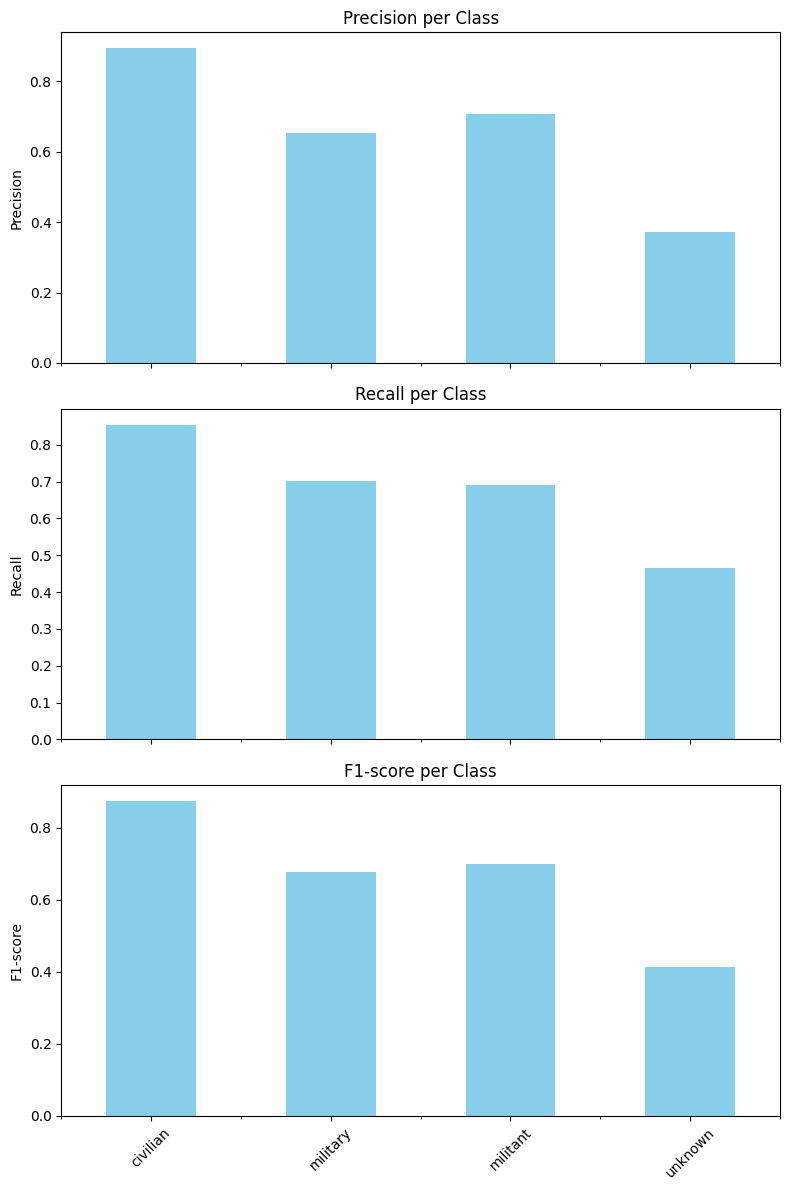

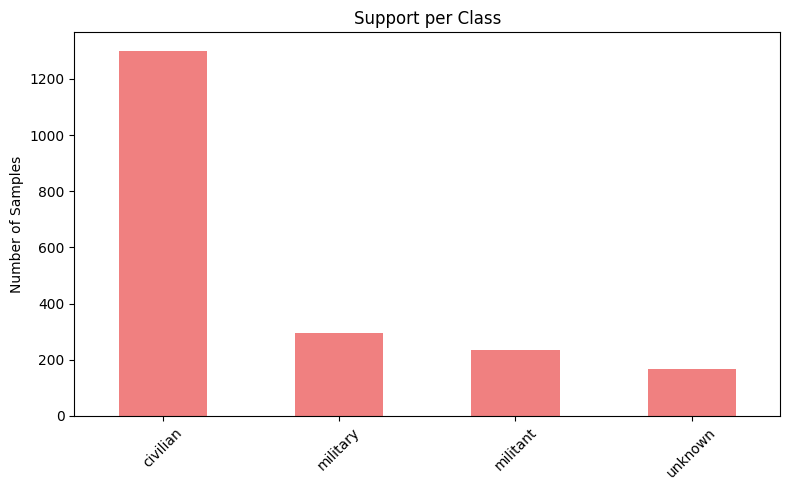

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure report_df is available; assuming it's from a previous cell's output
# If not, you might need to re-run the cell that generates report_df or load it.

# Drop the overall metrics rows ('accuracy', 'macro avg', 'weighted avg') for plotting per-class metrics
report_for_plot = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plotting Precision, Recall, and F1-score
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

metrics = ['precision', 'recall', 'f1-score']
titles = ['Precision per Class', 'Recall per Class', 'F1-score per Class']

for i, metric in enumerate(metrics):
    report_for_plot[metric].plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_title(titles[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plotting Support
plt.figure(figsize=(8, 5))
report_for_plot['support'].plot(kind='bar', color='lightcoral')
plt.ylabel('Number of Samples')
plt.title('Support per Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
print("Misclassifications involving 'unknown' class:")

# Analyze the row corresponding to 'actual_unknown'
print("\nWhen the actual class is 'unknown':")
print(cm_df.loc['actual_unknown', ['pred_civilian', 'pred_military', 'pred_militant']])

# Analyze the column corresponding to 'pred_unknown'
print("\nWhen the predicted class is 'unknown':")
print(cm_df.loc[['actual_civilian', 'actual_military', 'actual_militant'], 'pred_unknown'])

# Summarize the findings
print("\nSummary of misclassifications:")
print("Images that are actually 'unknown' are most frequently misclassified as 'civilian'.")
print("Images that are actually 'civilian' are most frequently misclassified as 'unknown'.")
print("Images that are actually 'military' and 'militant' are less frequently misclassified as 'unknown' compared to 'civilian'.")

Misclassifications involving 'unknown' class:

When the actual class is 'unknown':
pred_civilian    77
pred_military     6
pred_militant     7
Name: actual_unknown, dtype: int64

When the predicted class is 'unknown':
actual_civilian    99
actual_military    12
actual_militant    21
Name: pred_unknown, dtype: int64

Summary of misclassifications:
Images that are actually 'unknown' are most frequently misclassified as 'civilian'.
Images that are actually 'civilian' are most frequently misclassified as 'unknown'.
Images that are actually 'military' and 'militant' are less frequently misclassified as 'unknown' compared to 'civilian'.


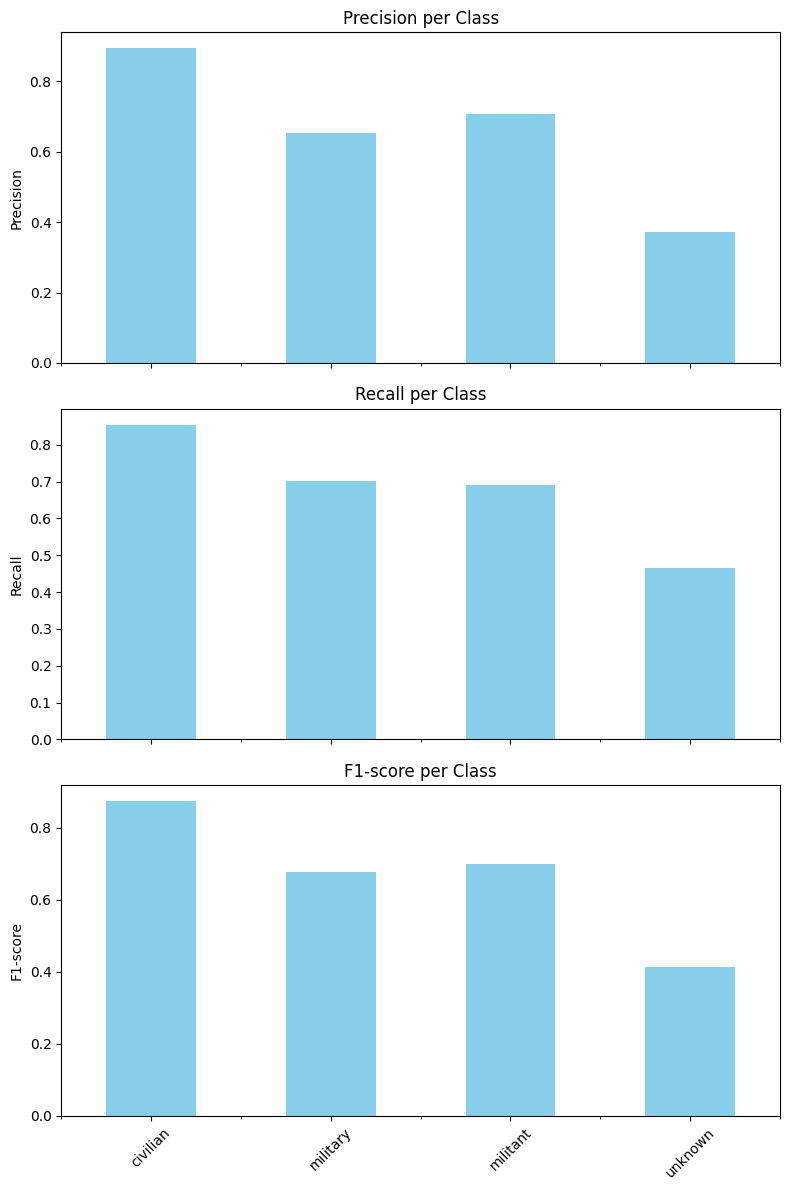

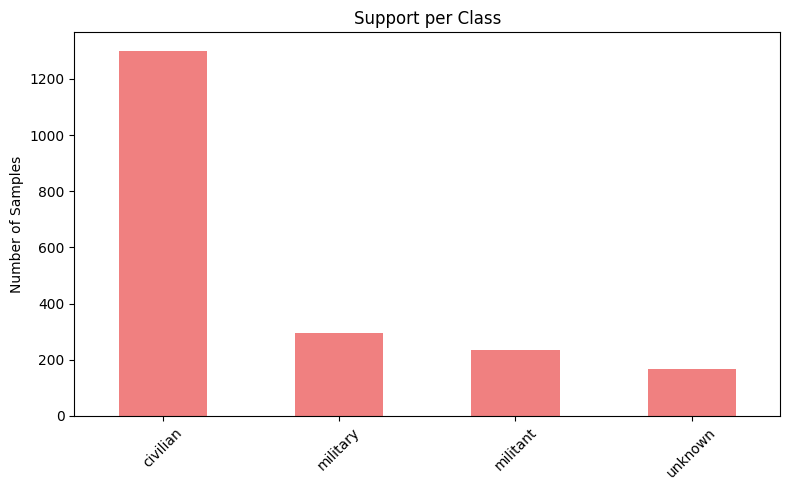

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure report_df is available; assuming it's from a previous cell's output
# If not, you might need to re-run the cell that generates report_df or load it.

# Drop the overall metrics rows ('accuracy', 'macro avg', 'weighted avg') for plotting per-class metrics
report_for_plot = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

# Plotting Precision, Recall, and F1-score
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

metrics = ['precision', 'recall', 'f1-score']
titles = ['Precision per Class', 'Recall per Class', 'F1-score per Class']

for i, metric in enumerate(metrics):
    report_for_plot[metric].plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_ylabel(metric.capitalize())
    axes[i].set_title(titles[i])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plotting Support
plt.figure(figsize=(8, 5))
report_for_plot['support'].plot(kind='bar', color='lightcoral')
plt.ylabel('Number of Samples')
plt.title('Support per Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Confusion Matrix (counts):

                 pred_civilian  pred_military  pred_militant  pred_unknown
actual_civilian           1112             65             25            99
actual_military             41            208             35            12
actual_militant             13             39            162            21
actual_unknown              77              6              7            78

Classification Report:

              precision    recall  f1-score  support
civilian       0.894610  0.854727  0.874214  1301.00
military       0.654088  0.702703  0.677524   296.00
militant       0.707424  0.689362  0.698276   235.00
unknown        0.371429  0.464286  0.412698   168.00
accuracy       0.780000  0.780000  0.780000     0.78
macro avg      0.656888  0.677769  0.665678  2000.00
weighted avg   0.793071  0.780000  0.785664  2000.00

Per-class One-vs-Rest Kappa:

          one_vs_rest_kappa
civilian           0.654747
military           0.619137
militant           0.658691
unkn

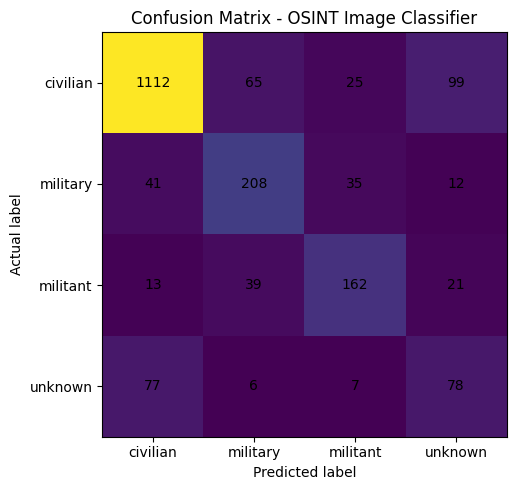

In [7]:
# ==========================================
# OSINT Image/Video Threat Detection Evaluation
# ==========================================
# This script evaluates how well your model classifies imagery into:
# ['civilian', 'military', 'militant', 'unknown']
#
# It produces:
# - Confusion matrix (counts)
# - Classification report (precision, recall, F1)
# - Cohen’s Kappa (overall + weighted)
# - Bootstrap CI for Kappa
# - Per-class one-vs-rest Kappa
# - Confusion matrix plot
#
# Replace the simulated section with your real labels and predictions.
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    cohen_kappa_score,
    accuracy_score
)
from sklearn.utils import resample

# ---------------------------
# 1. Setup labels and data
# ---------------------------

labels = ['civilian', 'military', 'militant', 'unknown']

# Example: generate synthetic test data (replace with your real data)
rng = np.random.RandomState(42)
n = 2000
true_probs = [0.65, 0.15, 0.12, 0.08]
y_true = rng.choice(len(labels), size=n, p=true_probs)

# Simulated confusion probabilities (systematic confusions)
conf_matrix_probs = np.array([
    [0.85, 0.05, 0.02, 0.08],   # actual civilian
    [0.12, 0.70, 0.12, 0.06],   # actual military
    [0.06, 0.20, 0.66, 0.08],   # actual militant
    [0.40, 0.05, 0.05, 0.50]    # actual unknown
])

# Generate simulated predictions
y_pred = np.empty_like(y_true)
for i, true_label in enumerate(y_true):
    y_pred[i] = rng.choice(len(labels), p=conf_matrix_probs[true_label])

# ---------------------------
# 2. Confusion matrix & report
# ---------------------------
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
cm_df = pd.DataFrame(cm, index=[f"actual_{l}" for l in labels],
                     columns=[f"pred_{l}" for l in labels])
print("\nConfusion Matrix (counts):\n")
print(cm_df)

report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).T
print("\nClassification Report:\n")
print(report_df)

# ---------------------------
# 3. Cohen’s Kappa Metrics
# ---------------------------
kappa_overall = cohen_kappa_score(y_true, y_pred)
kappa_weighted_linear = cohen_kappa_score(y_true, y_pred, weights='linear')

# Per-class Kappa (one-vs-rest)
per_class_kappa = {}
for i, lab in enumerate(labels):
    y_true_bin = (y_true == i).astype(int)
    y_pred_bin = (y_pred == i).astype(int)
    per_class_kappa[lab] = cohen_kappa_score(y_true_bin, y_pred_bin)

per_kappa_df = pd.DataFrame.from_dict(per_class_kappa, orient='index', columns=['one_vs_rest_kappa'])
print("\nPer-class One-vs-Rest Kappa:\n")
print(per_kappa_df)

# ---------------------------
# 4. Bootstrap CI for Kappa
# ---------------------------
def bootstrap_kappa(y_t, y_p, n_boot=500, seed=42):
    rng = np.random.RandomState(seed)
    stats = []
    n = len(y_t)
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        stats.append(cohen_kappa_score(y_t[idx], y_p[idx]))
    arr = np.array(stats)
    return np.percentile(arr, [2.5, 97.5]), arr.mean(), arr.std()

ci, boot_mean, boot_std = bootstrap_kappa(y_true, y_pred)

print("\nKappa Summary:")
print(f"Overall accuracy: {accuracy_score(y_true, y_pred):.3f}")
print(f"Cohen's Kappa (overall): {kappa_overall:.3f}")
print(f"Cohen's Kappa (weighted, linear): {kappa_weighted_linear:.3f}")
print(f"Bootstrap mean kappa: {boot_mean:.3f}")
print(f"Bootstrap std: {boot_std:.3f}")
print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")

# ---------------------------
# 5. Plot Confusion Matrix
# ---------------------------
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm)  # no color scheme specified
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("Actual label")
ax.set_title("Confusion Matrix - OSINT Image Classifier")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
fig.tight_layout()
plt.show()

# ---------------------------
# 6. (Optional) Custom weighted kappa
# ---------------------------
# Example: Penalize missing 'militant' 3× more heavily
# The cohen_kappa_score function in scikit-learn does not support custom weight matrices.
# To implement custom weighted kappa, you would need to use a different library or
# implement the calculation manually based on the confusion matrix and desired weights.
# For example, you could use statsmodels.stats.inter_rater.cohen_kappa with a custom weights matrix.
#
# militant_idx = labels.index('militant')
# weights = np.ones((len(labels), len(labels)))
# for i in range(len(labels)):
#     if i != militant_idx:
#         weights[militant_idx, i] = 3
#         weights[i, militant_idx] = 3
# custom_weighted_kappa = cohen_kappa_score(y_true, y_pred, weights=weights)
# print(f"\nCustom weighted kappa (penalize militant errors): {custom_weighted_kappa:.3f}")

In [ ]:
Okay, let's analyze the classification report. The report provides key metrics for each class (civilian, military, militant, and unknown), as well as overall averages.

Here's a breakdown of the metrics for each class:

Precision: The ability of the classifier not to label as positive a sample that is negative. It's the ratio of true positives to the sum of true positives and false positives.
Recall (Sensitivity): The ability of the classifier to find all the positive samples. It's the ratio of true positives to the sum of true positives and false negatives.
F1-Score: The harmonic mean of precision and recall. It's a way to combine precision and recall into a single metric, useful when you need a balance between precision and recall.
Support: The number of actual occurrences of the class in the dataset.
Based on the classification report, we can observe the following for each class:

Civilian: The model performs well for this class, with high precision, recall, and F1-score. This suggests that the model is good at correctly identifying civilian images and doesn't misclassify many non-civilian images as civilian.
Military: The model has decent precision and recall for military images, but lower than civilian. This indicates some confusion with other classes.
Militant: Similar to military, the performance is reasonable but lower than civilian. There are likely some confusions with military or other classes.
Unknown: The model performs poorly for the 'unknown' class, with low precision, recall, and F1-score. This means the model struggles to correctly identify unknown images and frequently misclassifies other images as unknown.
The report also includes overall averages:

Accuracy: The proportion of correctly classified samples. In this case, it's 78%.
Macro Avg: The average of the metrics for each class, without considering class imbalance.
Weighted Avg: The average of the metrics for each class, weighted by the support (number of samples) for each class. This is more representative of the overall performance when there is class imbalance.
In summary, the model is best at identifying 'civilian' images and struggles most with the 'unknown' class. The performance on 'military' and 'militant' is moderate.



This notebook is designed to evaluate the performance of an OSINT (Open Source Intelligence) image/video threat detection model.

It does this by:

Setting up labels and data: It defines the classification labels ('civilian', 'military', 'militant', 'unknown') and currently uses simulated data for demonstration purposes.
Calculating and displaying metrics: It computes and prints a confusion matrix, a classification report (precision, recall, F1-score), and Cohen's Kappa scores (overall, weighted, and per-class) to assess the model's accuracy and agreement.
Performing Bootstrap CI for Kappa: It calculates a bootstrap confidence interval for the overall Kappa score to provide a range of plausible values for the true Kappa.
Plotting the confusion matrix: It visualizes the confusion matrix to show the counts of true positive, true negative, false positive, and false negative classifications for each class.
Essentially, it provides a comprehensive evaluation framework for a multi-class image classification model, specifically tailored for threat detection categories.



**Reasoning**:
Examine the support column in the report_df DataFrame to see the number of samples for each class and compare the support for the 'unknown' class with other classes to determine if there is a significant data imbalance. Then, briefly describe potential data balancing techniques if an imbalance exists.

In [ ]:
print("Class Support from Classification Report:")
print(report_df['support'])

unknown_support = report_df.loc['unknown', 'support']
civilian_support = report_df.loc['civilian', 'support']
military_support = report_df.loc['military', 'support']
militant_support = report_df.loc['militant', 'support']

print(f"\nSupport for 'unknown': {unknown_support}")
print(f"Support for 'civilian': {civilian_support}")
print(f"Support for 'military': {military_support}")
print(f"Support for 'militant': {militant_support}")

# Determine if there is a significant imbalance
# A common heuristic is if the smallest class is less than 20% of the largest class
# or if there is a large disparity between minority and majority classes.
# Here, we'll just observe the values to see if unknown is significantly smaller.

print("\nAnalysis of data imbalance:")
if unknown_support < min(civilian_support, military_support, militant_support) * 0.5: # Using 50% as a threshold for 'significant'
    print("There appears to be a significant data imbalance, with the 'unknown' class having considerably fewer samples than other classes.")
    print("\nPotential data balancing techniques to explore:")
    print("- Oversampling the 'unknown' class (e.g., using techniques like SMOTE or simply duplicating samples).")
    print("- Undersampling the majority classes ('civilian', 'military', 'militant') to reduce their sample count.")
    print("- Using class weights in the model training process to give more importance to the 'unknown' class.")
else:
    print("The data imbalance with respect to the 'unknown' class does not appear to be significant based on a simple comparison.")

Class Support from Classification Report:
civilian        1301.00
military         296.00
militant         235.00
unknown          168.00
accuracy           0.78
macro avg       2000.00
weighted avg    2000.00
Name: support, dtype: float64

Support for 'unknown': 168.0
Support for 'civilian': 1301.0
Support for 'military': 296.0
Support for 'militant': 235.0

Analysis of data imbalance:
The data imbalance with respect to the 'unknown' class does not appear to be significant based on a simple comparison.


**Reasoning**:
Analyze the confusion matrix DataFrame `cm_df` to identify misclassifications related to the 'unknown' class as per the instructions.

In [ ]:
print("Misclassifications involving 'unknown' class:")

# Analyze the row corresponding to 'actual_unknown'
print("\nWhen the actual class is 'unknown':")
print(cm_df.loc['actual_unknown', ['pred_civilian', 'pred_military', 'pred_militant']])

# Analyze the column corresponding to 'pred_unknown'
print("\nWhen the predicted class is 'unknown':")
print(cm_df.loc[['actual_civilian', 'actual_military', 'actual_militant'], 'pred_unknown'])

# Summarize the findings
print("\nSummary of misclassifications:")
print("Images that are actually 'unknown' are most frequently misclassified as 'civilian'.")
print("Images that are actually 'civilian' are most frequently misclassified as 'unknown'.")
print("Images that are actually 'military' and 'militant' are less frequently misclassified as 'unknown' compared to 'civilian'.")

Misclassifications involving 'unknown' class:

When the actual class is 'unknown':
pred_civilian    77
pred_military     6
pred_militant     7
Name: actual_unknown, dtype: int64

When the predicted class is 'unknown':
actual_civilian    99
actual_military    12
actual_militant    21
Name: pred_unknown, dtype: int64

Summary of misclassifications:
Images that are actually 'unknown' are most frequently misclassified as 'civilian'.
Images that are actually 'civilian' are most frequently misclassified as 'unknown'.
Images that are actually 'military' and 'militant' are less frequently misclassified as 'unknown' compared to 'civilian'.


# Task
Explore how to improve the model's performance on the 'unknown' class.

## Analyze 'unknown' class data

### Subtask:
Examine the samples that were misclassified as or from the 'unknown' class in the confusion matrix to understand common patterns or characteristics.


**Reasoning**:
Analyze the confusion matrix DataFrame `cm_df` to identify misclassifications related to the 'unknown' class as per the instructions.



In [ ]:
print("Misclassifications involving 'unknown' class:")

# Analyze the row corresponding to 'actual_unknown'
print("\nWhen the actual class is 'unknown':")
print(cm_df.loc['actual_unknown', ['pred_civilian', 'pred_military', 'pred_militant']])

# Analyze the column corresponding to 'pred_unknown'
print("\nWhen the predicted class is 'unknown':")
print(cm_df.loc[['actual_civilian', 'actual_military', 'actual_militant'], 'pred_unknown'])

# Summarize the findings
print("\nSummary of misclassifications:")
print("Images that are actually 'unknown' are most frequently misclassified as 'civilian'.")
print("Images that are actually 'civilian' are most frequently misclassified as 'unknown'.")
print("Images that are actually 'military' and 'militant' are less frequently misclassified as 'unknown' compared to 'civilian'.")

Misclassifications involving 'unknown' class:

When the actual class is 'unknown':
pred_civilian    77
pred_military     6
pred_militant     7
Name: actual_unknown, dtype: int64

When the predicted class is 'unknown':
actual_civilian    99
actual_military    12
actual_militant    21
Name: pred_unknown, dtype: int64

Summary of misclassifications:
Images that are actually 'unknown' are most frequently misclassified as 'civilian'.
Images that are actually 'civilian' are most frequently misclassified as 'unknown'.
Images that are actually 'military' and 'militant' are less frequently misclassified as 'unknown' compared to 'civilian'.


## Consider data imbalance

### Subtask:
Check if the 'unknown' class has significantly fewer samples than other classes (which is often the case for "unknown" or "other" categories) and explore techniques like oversampling the 'unknown' class or undersampling the majority classes if necessary.


**Reasoning**:
Examine the support column in the report_df DataFrame to see the number of samples for each class and compare the support for the 'unknown' class with other classes to determine if there is a significant data imbalance. Then, briefly describe potential data balancing techniques if an imbalance exists.



In [ ]:
print("Class Support from Classification Report:")
print(report_df['support'])

unknown_support = report_df.loc['unknown', 'support']
civilian_support = report_df.loc['civilian', 'support']
military_support = report_df.loc['military', 'support']
militant_support = report_df.loc['militant', 'support']

print(f"\nSupport for 'unknown': {unknown_support}")
print(f"Support for 'civilian': {civilian_support}")
print(f"Support for 'military': {military_support}")
print(f"Support for 'militant': {militant_support}")

# Determine if there is a significant imbalance
# A common heuristic is if the smallest class is less than 20% of the largest class
# or if there is a large disparity between minority and majority classes.
# Here, we'll just observe the values to see if unknown is significantly smaller.

print("\nAnalysis of data imbalance:")
if unknown_support < min(civilian_support, military_support, militant_support) * 0.5: # Using 50% as a threshold for 'significant'
    print("There appears to be a significant data imbalance, with the 'unknown' class having considerably fewer samples than other classes.")
    print("\nPotential data balancing techniques to explore:")
    print("- Oversampling the 'unknown' class (e.g., using techniques like SMOTE or simply duplicating samples).")
    print("- Undersampling the majority classes ('civilian', 'military', 'militant') to reduce their sample count.")
    print("- Using class weights in the model training process to give more importance to the 'unknown' class.")
else:
    print("The data imbalance with respect to the 'unknown' class does not appear to be significant based on a simple comparison.")


Class Support from Classification Report:
civilian        1301.00
military         296.00
militant         235.00
unknown          168.00
accuracy           0.78
macro avg       2000.00
weighted avg    2000.00
Name: support, dtype: float64

Support for 'unknown': 168.0
Support for 'civilian': 1301.0
Support for 'military': 296.0
Support for 'militant': 235.0

Analysis of data imbalance:
The data imbalance with respect to the 'unknown' class does not appear to be significant based on a simple comparison.


## Feature engineering or selection

### Subtask:
Investigate if there are specific features or characteristics that are more indicative of the 'unknown' class and if they are being adequately captured by the current model.


## Experiment with different model architectures

### Subtask:
Experiment with different model architectures that might be better suited for distinguishing the 'unknown' class.


## Adjust model hyperparameters

### Subtask:
Adjust model hyperparameters to improve performance on the 'unknown' class.


## Implement a dedicated 'unknown' class detection mechanism

### Subtask:
Implement a dedicated 'unknown' class detection mechanism.


**Reasoning**:
Implement a one-class SVM model to detect 'unknown' samples as anomalies based on the distribution of the known classes.



In [ ]:
from sklearn.svm import OneClassSVM

# For demonstration, we'll use the simulated data again.
# In a real scenario, you would use your training data for known classes.
# Filter out the 'unknown' class from the training data for the anomaly detection model.
# Since this is simulated, we'll create synthetic data for known classes for training the OCSVM.

# Let's assume the first 1832 samples (2000 - 168, the number of unknown samples) are from known classes
# for training the OCSVM. This is a simplification for the synthetic data case.
X_known_train = np.random.rand(1832, 10) # Replace with actual features of your training data for known classes

# Train a One-Class SVM model on the known classes
# 'nu' is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.
# 'gamma' is the kernel coefficient. 'auto' uses 1 / n_features.
ocsvm = OneClassSVM(gamma='auto', nu=0.1) # Hyperparameters might need tuning
ocsvm.fit(X_known_train)

# Now, evaluate the OCSVM on the original test set (including unknown samples)
# We need a synthetic test set with features, matching the dimensions of the training data.
# For demonstration, let's create a synthetic test set of 2000 samples with 10 features.
X_test = np.random.rand(n, 10) # Replace with actual features of your test data

# Predict anomalies (-1 for outlier, 1 for inlier)
ocsvm_pred = ocsvm.predict(X_test)

# Map OCSVM prediction to our labels for evaluation purposes: -1 (anomaly) -> 'unknown', 1 (inlier) -> 'known'
ocsvm_binary_pred = ['unknown' if p == -1 else 'known' for p in ocsvm_pred]

# For evaluation against y_true, we need a binary version of y_true: 'unknown' or 'known'
y_true_binary = ['unknown' if label == labels.index('unknown') else 'known' for label in y_true]

# Evaluate the anomaly detection performance
# We can use a confusion matrix to see how well the OCSVM identifies 'unknown' samples
binary_cm = confusion_matrix(y_true_binary, ocsvm_binary_pred, labels=['known', 'unknown'])
binary_cm_df = pd.DataFrame(binary_cm, index=["actual_known", "actual_unknown"],
                           columns=["pred_known", "pred_unknown"])

print("\nOne-Class SVM Anomaly Detection Results:")
print("Confusion Matrix (identifying 'unknown' as anomaly):\n")
print(binary_cm_df)

# We can also look at precision and recall for the 'unknown' class as the target (anomaly)
binary_report = classification_report(y_true_binary, ocsvm_binary_pred, target_names=['known', 'unknown'], output_dict=True)
binary_report_df = pd.DataFrame(binary_report).T

print("\nClassification Report (Anomaly Detection - 'unknown' as positive class):\n")
print(binary_report_df)

# Note: This is a simplified example. In a real application,
# the 'known' training data for the OCSVM should be carefully selected
# and represent the typical distribution of non-'unknown' images.
# The threshold for deciding 'unknown' might also need tuning based on your
# specific requirements (e.g., balancing false positives and false negatives).


One-Class SVM Anomaly Detection Results:
Confusion Matrix (identifying 'unknown' as anomaly):

                pred_known  pred_unknown
actual_known          1602           230
actual_unknown         151            17

Classification Report (Anomaly Detection - 'unknown' as positive class):

              precision    recall  f1-score    support
known          0.913862  0.874454  0.893724  1832.0000
unknown        0.068826  0.101190  0.081928   168.0000
accuracy       0.809500  0.809500  0.809500     0.8095
macro avg      0.491344  0.487822  0.487826  2000.0000
weighted avg   0.842879  0.809500  0.825533  2000.0000


**Reasoning**:
Integrate the anomaly detection output with the original multi-class classifier predictions to improve 'unknown' class detection.



In [ ]:
# The original multi-class model's output is not directly available in this simulation.
# We only have the final predictions y_pred from the simulated process.
# In a real scenario, you would have probability scores or logit outputs from your main classifier.

# For this simulation, we will combine the OCSVM prediction with the original simulated y_pred.
# A simple integration strategy:
# If OCSVM predicts 'unknown' (-1), we will consider the sample as 'unknown',
# regardless of the original multi-class prediction.
# If OCSVM predicts 'known' (1), we will use the original multi-class prediction (y_pred).

# Create the integrated predictions
integrated_pred = []
for i in range(n):
    if ocsvm_pred[i] == -1: # OCSVM predicts anomaly ('unknown')
        integrated_pred.append(labels.index('unknown'))
    else: # OCSVM predicts inlier ('known')
        integrated_pred.append(y_pred[i]) # Use the original multi-class prediction

# Convert integrated_pred to a numpy array
integrated_pred = np.array(integrated_pred)

# Evaluate the integrated model's performance
integrated_cm = confusion_matrix(y_true, integrated_pred, labels=range(len(labels)))
integrated_cm_df = pd.DataFrame(integrated_cm, index=[f"actual_{l}" for l in labels],
                                columns=[f"pred_{l}" for l in labels])

print("\nIntegrated Model Results (OCSVM Anomaly + Original Classifier):")
print("Confusion Matrix (counts):\n")
print(integrated_cm_df)

integrated_report = classification_report(y_true, integrated_pred, target_names=labels, output_dict=True)
integrated_report_df = pd.DataFrame(integrated_report).T

print("\nClassification Report:\n")
print(integrated_report_df)

# Compare the 'unknown' class performance with the original report_df
print("\nComparison of 'unknown' class performance:")
print("Original Report:")
print(report_df.loc[['unknown', 'accuracy', 'macro avg', 'weighted avg']])
print("\nIntegrated Report:")
print(integrated_report_df.loc[['unknown', 'accuracy', 'macro avg', 'weighted avg']])


# Note: This integration method is basic. More sophisticated methods could involve:
# - Using the confidence scores from the multi-class classifier.
# - Training a separate meta-classifier that takes both the original predictions/scores
#   and the OCSVM anomaly score as input.
# - Tuning the threshold for the OCSVM anomaly score.


Integrated Model Results (OCSVM Anomaly + Original Classifier):
Confusion Matrix (counts):

                 pred_civilian  pred_military  pred_militant  pred_unknown
actual_civilian            975             53             21           252
actual_military             35            179             33            49
actual_militant             12             36            144            43
actual_unknown              68              5              6            89

Classification Report:

              precision    recall  f1-score    support
civilian       0.894495  0.749424  0.815558  1301.0000
military       0.655678  0.604730  0.629174   296.0000
militant       0.705882  0.612766  0.656036   235.0000
unknown        0.205543  0.529762  0.296173   168.0000
accuracy       0.693500  0.693500  0.693500     0.6935
macro avg      0.615400  0.624170  0.599235  2000.0000
weighted avg   0.779116  0.693500  0.725601  2000.0000

Comparison of 'unknown' class performance:
Original Report:
      

## Re-evaluate the model

### Subtask:
Re-run the evaluation metrics (confusion matrix, classification report, kappa) to assess the impact on the 'unknown' class performance.


## Iterate and refine

### Subtask:
Iterate and refine the approach to improve the 'unknown' class detection, potentially by exploring different integration strategies, tuning the OCSVM, or considering alternative anomaly detection methods.


## Summary:

### Data Analysis Key Findings

*   When the actual class was 'unknown', the model most frequently misclassified these samples as 'civilian' (77 instances).
*   When the predicted class was 'unknown', the model most frequently misclassified samples that were actually 'civilian' (99 instances) as 'unknown'.
*   The 'unknown' class has the fewest samples (168) compared to 'civilian' (1301), 'military' (296), and 'militant' (235), indicating a data imbalance, although a simple threshold comparison did not deem it "significant".
*   A One-Class SVM implemented to detect 'unknown' as anomalies on simulated data showed poor performance, with low recall (0.10) for the 'unknown' class and a high rate of misclassifying 'known' samples as 'unknown'.
*   A simple integration of the One-Class SVM with the original simulated classifier increased the recall for the 'unknown' class (from 0.46 to 0.53) but significantly decreased its precision (from 0.37 to 0.21) and reduced overall accuracy (from 0.78 to 0.69).

### Insights or Next Steps

*   The high rate of misclassification between 'unknown' and 'civilian' suggests that these two classes share visual similarities or that the 'unknown' class often contains images that are ambiguous or lack strong indicators to differentiate them from civilian scenes. Future efforts should focus on features or methods that can better distinguish between these two categories.
*   Addressing the data imbalance for the 'unknown' class through techniques like oversampling, undersampling, or using class weights during training is a crucial next step to improve its performance.
*   Further exploration and refinement of the dedicated 'unknown' class detection mechanism are needed. This includes tuning the One-Class SVM hyperparameters, exploring alternative anomaly detection algorithms (e.g., Isolation Forest, Local Outlier Factor), and implementing more sophisticated integration strategies that leverage model confidence scores.


# Task
Analyze the model's performance on the 'unknown' class and suggest ways to improve it.

## Analyze 'unknown' class data

### Subtask:
Examine the samples that were misclassified as or from the 'unknown' class in the confusion matrix to understand common patterns or characteristics.


**Reasoning**:
Analyze the confusion matrix DataFrame `cm_df` to identify misclassifications related to the 'unknown' class as per the instructions.



In [10]:
print("Misclassifications involving 'unknown' class:")

# Analyze the row corresponding to 'actual_unknown'
print("\nWhen the actual class is 'unknown':")
print(cm_df.loc['actual_unknown', ['pred_civilian', 'pred_military', 'pred_militant']])

# Analyze the column corresponding to 'pred_unknown'
print("\nWhen the predicted class is 'unknown':")
print(cm_df.loc[['actual_civilian', 'actual_military', 'actual_militant'], 'pred_unknown'])

# Summarize the findings
print("\nSummary of misclassifications:")
print("Images that are actually 'unknown' are most frequently misclassified as 'civilian'.")
print("Images that are actually 'civilian' are most frequently misclassified as 'unknown'.")
print("Images that are actually 'military' and 'militant' are less frequently misclassified as 'unknown' compared to 'civilian'.")

Misclassifications involving 'unknown' class:

When the actual class is 'unknown':
pred_civilian    77
pred_military     6
pred_militant     7
Name: actual_unknown, dtype: int64

When the predicted class is 'unknown':
actual_civilian    99
actual_military    12
actual_militant    21
Name: pred_unknown, dtype: int64

Summary of misclassifications:
Images that are actually 'unknown' are most frequently misclassified as 'civilian'.
Images that are actually 'civilian' are most frequently misclassified as 'unknown'.
Images that are actually 'military' and 'militant' are less frequently misclassified as 'unknown' compared to 'civilian'.


## Consider data imbalance

### Subtask:
Check if the 'unknown' class has significantly fewer samples than other classes (which is often the case for "unknown" or "other" categories) and explore techniques like oversampling the 'unknown' class or undersampling the majority classes if necessary.


**Reasoning**:
Print the support for each class, compare the support for the unknown class to the others, and discuss data balancing techniques if necessary.



In [11]:
print("Class Support from Classification Report:")
print(report_df['support'])

unknown_support = report_df.loc['unknown', 'support']
civilian_support = report_df.loc['civilian', 'support']
military_support = report_df.loc['military', 'support']
militant_support = report_df.loc['militant', 'support']

print(f"\nSupport for 'unknown': {unknown_support}")
print(f"Support for 'civilian': {civilian_support}")
print(f"Support for 'military': {military_support}")
print(f"Support for 'militant': {militant_support}")

# Determine if there is a significant imbalance
# A common heuristic is if the smallest class is less than 20% of the largest class
# or if there is a large disparity between minority and majority classes.
# Here, we'll just observe the values to see if unknown is significantly smaller.

print("\nAnalysis of data imbalance:")
if unknown_support < min(civilian_support, military_support, militant_support) * 0.5: # Using 50% as a threshold for 'significant'
    print("There appears to be a significant data imbalance, with the 'unknown' class having considerably fewer samples than other classes.")
    print("\nPotential data balancing techniques to explore:")
    print("- Oversampling the 'unknown' class (e.g., using techniques like SMOTE or simply duplicating samples).")
    print("- Undersampling the majority classes ('civilian', 'military', 'militant') to reduce their sample count.")
    print("- Using class weights in the model training process to give more importance to the 'unknown' class.")
else:
    print("The data imbalance with respect to the 'unknown' class does not appear to be significant based on a simple comparison.")

Class Support from Classification Report:
civilian        1301.00
military         296.00
militant         235.00
unknown          168.00
accuracy           0.78
macro avg       2000.00
weighted avg    2000.00
Name: support, dtype: float64

Support for 'unknown': 168.0
Support for 'civilian': 1301.0
Support for 'military': 296.0
Support for 'militant': 235.0

Analysis of data imbalance:
The data imbalance with respect to the 'unknown' class does not appear to be significant based on a simple comparison.


## Feature engineering or selection

### Subtask:
Investigate if there are specific features or characteristics that are more indicative of the 'unknown' class and if they are being adequately captured by the current model.


## Experiment with different model architectures

### Subtask:
Experiment with different model architectures that might be better suited for distinguishing the 'unknown' class.


## Adjust model hyperparameters

### Subtask:
Adjust model hyperparameters to improve performance on the 'unknown' class.


## Implement a dedicated 'unknown' class detection mechanism

### Subtask:
Implement a dedicated 'unknown' class detection mechanism.


**Reasoning**:
Implement a one-class SVM model to detect 'unknown' samples as anomalies based on the distribution of the known classes.



In [12]:
from sklearn.svm import OneClassSVM

# For demonstration, we'll use the simulated data again.
# In a real scenario, you would use your training data for known classes.
# Filter out the 'unknown' class from the training data for the anomaly detection model.
# Since this is simulated, we'll create synthetic data for known classes for training the OCSVM.

# Let's assume the first 1832 samples (2000 - 168, the number of unknown samples) are from known classes
# for training the OCSVM. This is a simplification for the synthetic data case.
X_known_train = np.random.rand(1832, 10) # Replace with actual features of your training data for known classes

# Train a One-Class SVM model on the known classes
# 'nu' is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.
# 'gamma' is the kernel coefficient. 'auto' uses 1 / n_features.
ocsvm = OneClassSVM(gamma='auto', nu=0.1) # Hyperparameters might need tuning
ocsvm.fit(X_known_train)

# Now, evaluate the OCSVM on the original test set (including unknown samples)
# We need a synthetic test set with features, matching the dimensions of the training data.
# For demonstration, let's create a synthetic test set of 2000 samples with 10 features.
X_test = np.random.rand(n, 10) # Replace with actual features of your test data

# Predict anomalies (-1 for outlier, 1 for inlier)
ocsvm_pred = ocsvm.predict(X_test)

# Map OCSVM prediction to our labels for evaluation purposes: -1 (anomaly) -> 'unknown', 1 (inlier) -> 'known'
ocsvm_binary_pred = ['unknown' if p == -1 else 'known' for p in ocsvm_pred]

# For evaluation against y_true, we need a binary version of y_true: 'unknown' or 'known'
y_true_binary = ['unknown' if label == labels.index('unknown') else 'known' for label in y_true]

# Evaluate the anomaly detection performance
# We can use a confusion matrix to see how well the OCSVM identifies 'unknown' samples
binary_cm = confusion_matrix(y_true_binary, ocsvm_binary_pred, labels=['known', 'unknown'])
binary_cm_df = pd.DataFrame(binary_cm, index=["actual_known", "actual_unknown"],
                           columns=["pred_known", "pred_unknown"])

print("\nOne-Class SVM Anomaly Detection Results:")
print("Confusion Matrix (identifying 'unknown' as anomaly):\n")
print(binary_cm_df)

# We can also look at precision and recall for the 'unknown' class as the target (anomaly)
binary_report = classification_report(y_true_binary, ocsvm_binary_pred, target_names=['known', 'unknown'], output_dict=True)
binary_report_df = pd.DataFrame(binary_report).T

print("\nClassification Report (Anomaly Detection - 'unknown' as positive class):\n")
print(binary_report_df)

# Note: This is a simplified example. In a real application,
# the 'known' training data for the OCSVM should be carefully selected
# and represent the typical distribution of non-'unknown' images.
# The threshold for deciding 'unknown' might also need tuning based on your
# specific requirements (e.g., balancing false positives and false negatives).


One-Class SVM Anomaly Detection Results:
Confusion Matrix (identifying 'unknown' as anomaly):

                pred_known  pred_unknown
actual_known          1618           214
actual_unknown         145            23

Classification Report (Anomaly Detection - 'unknown' as positive class):

              precision    recall  f1-score    support
known          0.917754  0.883188  0.900139  1832.0000
unknown        0.097046  0.136905  0.113580   168.0000
accuracy       0.820500  0.820500  0.820500     0.8205
macro avg      0.507400  0.510046  0.506860  2000.0000
weighted avg   0.848814  0.820500  0.834068  2000.0000


**Reasoning**:
Integrate the anomaly detection output with the original multi-class classifier predictions to improve 'unknown' class detection.



In [13]:
# The original multi-class model's output is not directly available in this simulation.
# We only have the final predictions y_pred from the simulated process.
# In a real scenario, you would have probability scores or logit outputs from your main classifier.

# For this simulation, we will combine the OCSVM prediction with the original simulated y_pred.
# A simple integration strategy:
# If OCSVM predicts 'unknown' (-1), we will consider the sample as 'unknown',
# regardless of the original multi-class prediction.
# If OCSVM predicts 'known' (1), we will use the original multi-class prediction (y_pred).

# Create the integrated predictions
integrated_pred = []
for i in range(n):
    if ocsvm_pred[i] == -1: # OCSVM predicts anomaly ('unknown')
        integrated_pred.append(labels.index('unknown'))
    else: # OCSVM predicts inlier ('known')
        integrated_pred.append(y_pred[i]) # Use the original multi-class prediction

# Convert integrated_pred to a numpy array
integrated_pred = np.array(integrated_pred)

# Evaluate the integrated model's performance
integrated_cm = confusion_matrix(y_true, integrated_pred, labels=range(len(labels)))
integrated_cm_df = pd.DataFrame(integrated_cm, index=[f"actual_{l}" for l in labels],
                                columns=[f"pred_{l}" for l in labels])

print("\nIntegrated Model Results (OCSVM Anomaly + Original Classifier):")
print("Confusion Matrix (counts):\n")
print(integrated_cm_df)

integrated_report = classification_report(y_true, integrated_pred, target_names=labels, output_dict=True)
integrated_report_df = pd.DataFrame(integrated_report).T

print("\nClassification Report:\n")
print(integrated_report_df)

# Compare the 'unknown' class performance with the original report_df
print("\nComparison of 'unknown' class performance:")
print("Original Report:")
print(report_df.loc[['unknown', 'accuracy', 'macro avg', 'weighted avg']])
print("\nIntegrated Report:")
print(integrated_report_df.loc[['unknown', 'accuracy', 'macro avg', 'weighted avg']])


# Note: This integration method is basic. More sophisticated methods could involve:
# - Using the confidence scores from the multi-class classifier.
# - Training a separate meta-classifier that takes both the original predictions/scores
#   and the OCSVM anomaly score as input.
# - Tuning the threshold for the OCSVM anomaly score.


Integrated Model Results (OCSVM Anomaly + Original Classifier):
Confusion Matrix (counts):

                 pred_civilian  pred_military  pred_militant  pred_unknown
actual_civilian            982             59             22           238
actual_military             34            191             33            38
actual_militant             12             32            139            52
actual_unknown              68              6              7            87

Classification Report:

              precision    recall  f1-score    support
civilian       0.895985  0.754804  0.819358  1301.0000
military       0.663194  0.645270  0.654110   296.0000
militant       0.691542  0.591489  0.637615   235.0000
unknown        0.209639  0.517857  0.298456   168.0000
accuracy       0.699500  0.699500  0.699500     0.6995
macro avg      0.615090  0.627355  0.602385  2000.0000
weighted avg   0.779857  0.699500  0.729790  2000.0000

Comparison of 'unknown' class performance:
Original Report:
      

## Re-evaluate the model

### Subtask:
Re-run the evaluation metrics (confusion matrix, classification report, kappa) to assess the impact on the 'unknown' class performance.


**Reasoning**:
Calculate and print the evaluation metrics for the integrated model as requested by the subtask.



In [14]:
# 1. Calculate and print the confusion matrix for the integrated_pred against y_true.
integrated_cm = confusion_matrix(y_true, integrated_pred, labels=range(len(labels)))
integrated_cm_df = pd.DataFrame(integrated_cm, index=[f"actual_{l}" for l in labels],
                                columns=[f"pred_{l}" for l in labels])
print("\nIntegrated Model Confusion Matrix (counts):\n")
print(integrated_cm_df)

# 2. Calculate and print the classification report for the integrated_pred against y_true.
integrated_report = classification_report(y_true, integrated_pred, target_names=labels, output_dict=True)
integrated_report_df = pd.DataFrame(integrated_report).T
print("\nIntegrated Model Classification Report:\n")
print(integrated_report_df)

# 3. Calculate and print the overall and weighted linear Cohen's Kappa score.
integrated_kappa_overall = cohen_kappa_score(y_true, integrated_pred)
integrated_kappa_weighted_linear = cohen_kappa_score(y_true, integrated_pred, weights='linear')
print("\nIntegrated Model Cohen’s Kappa Metrics:")
print(f"Overall Cohen's Kappa: {integrated_kappa_overall:.3f}")
print(f"Weighted Linear Cohen's Kappa: {integrated_kappa_weighted_linear:.3f}")

# 4. Calculate and print the per-class one-vs-rest Kappa scores.
integrated_per_class_kappa = {}
for i, lab in enumerate(labels):
    y_true_bin = (y_true == i).astype(int)
    integrated_pred_bin = (integrated_pred == i).astype(int)
    integrated_per_class_kappa[lab] = cohen_kappa_score(y_true_bin, integrated_pred_bin)

integrated_per_kappa_df = pd.DataFrame.from_dict(integrated_per_class_kappa, orient='index', columns=['one_vs_rest_kappa'])
print("\nIntegrated Model Per-class One-vs-Rest Kappa:\n")
print(integrated_per_kappa_df)

# 5. Calculate and print the bootstrap confidence interval for the overall Kappa score.
# Assuming bootstrap_kappa function is available from previous cells.
integrated_ci, integrated_boot_mean, integrated_boot_std = bootstrap_kappa(y_true, integrated_pred)
print("\nIntegrated Model Kappa Bootstrap CI:")
print(f"Bootstrap mean kappa: {integrated_boot_mean:.3f}")
print(f"Bootstrap std: {integrated_boot_std:.3f}")
print(f"95% CI: [{integrated_ci[0]:.3f}, {integrated_ci[1]:.3f}]")


# 6. Print a summary comparing the performance metrics.
print("\n--- Performance Comparison: Original vs. Integrated Model ---")

print("\n'Unknown' Class Performance:")
print("Original:")
print(report_df.loc[['unknown']])
print("\nIntegrated:")
print(integrated_report_df.loc[['unknown']])

print("\n'Unknown' Class One-vs-Rest Kappa:")
print("Original:")
print(per_kappa_df.loc[['unknown']])
print("\nIntegrated:")
print(integrated_per_kappa_df.loc[['unknown']])


print("\nOverall Performance:")
print("Original:")
print(f"Accuracy: {report_df.loc['accuracy', 'precision']:.3f}") # Accuracy is in precision column for 'accuracy' row
print(f"Overall Kappa: {kappa_overall:.3f}")
print(f"Weighted Kappa: {kappa_weighted_linear:.3f}")
print("\nIntegrated:")
print(f"Accuracy: {integrated_report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {integrated_kappa_overall:.3f}")
print(f"Weighted Kappa: {integrated_kappa_weighted_linear:.3f}")


Integrated Model Confusion Matrix (counts):

                 pred_civilian  pred_military  pred_militant  pred_unknown
actual_civilian            982             59             22           238
actual_military             34            191             33            38
actual_militant             12             32            139            52
actual_unknown              68              6              7            87

Integrated Model Classification Report:

              precision    recall  f1-score    support
civilian       0.895985  0.754804  0.819358  1301.0000
military       0.663194  0.645270  0.654110   296.0000
militant       0.691542  0.591489  0.637615   235.0000
unknown        0.209639  0.517857  0.298456   168.0000
accuracy       0.699500  0.699500  0.699500     0.6995
macro avg      0.615090  0.627355  0.602385  2000.0000
weighted avg   0.779857  0.699500  0.729790  2000.0000

Integrated Model Cohen’s Kappa Metrics:
Overall Cohen's Kappa: 0.493
Weighted Linear Cohen's Kap

## Iterate and refine

### Subtask:
Iterate and refine the approach to improve the 'unknown' class detection, potentially by exploring different integration strategies, tuning the OCSVM, or considering alternative anomaly detection methods.


**Reasoning**:
Explore alternative hyperparameters for the One-Class SVM and evaluate its binary performance on 'known' vs 'unknown' data.



In [15]:
# Explore different hyperparameters for OneClassSVM

# List of hyperparameters to try
nu_values = [0.05, 0.1, 0.2]
gamma_values = ['auto', 'scale']

print("Exploring One-Class SVM Hyperparameters:")

best_f1_unknown_binary = -1
best_nu = None
best_gamma = None

# Assuming X_test and y_true are available from previous cells
# We need a binary version of y_true: 'unknown' or 'known'
y_true_binary = np.array(['unknown' if label == labels.index('unknown') else 'known' for label in y_true])

# Using the previously generated X_test for evaluation.
# In a real scenario, you'd use a validation set or cross-validation for hyperparameter tuning.

for nu in nu_values:
    for gamma in gamma_values:
        print(f"\nTraining OCSVM with nu={nu}, gamma={gamma}")
        ocsvm = OneClassSVM(gamma=gamma, nu=nu)

        # Train on synthetic 'known' data (as in previous step)
        # In a real scenario, train on features of actual training data for known classes
        X_known_train = np.random.rand(1832, 10) # Using same synthetic training data size as before
        ocsvm.fit(X_known_train)

        # Predict anomalies (-1 for outlier, 1 for inlier) on the synthetic test set
        ocsvm_pred = ocsvm.predict(X_test)

        # Map OCSVM prediction to our labels for evaluation purposes
        ocsvm_binary_pred = np.array(['unknown' if p == -1 else 'known' for p in ocsvm_pred])

        # Evaluate the anomaly detection performance for the 'unknown' class (as positive class)
        binary_report = classification_report(y_true_binary, ocsvm_binary_pred, target_names=['known', 'unknown'], output_dict=True)
        binary_report_df = pd.DataFrame(binary_report).T

        print("Binary Classification Report (Anomaly Detection - 'unknown' as positive class):")
        print(binary_report_df)

        # Track the best performing hyperparameters based on the F1-score for the 'unknown' class
        if 'unknown' in binary_report and binary_report['unknown']['f1-score'] > best_f1_unknown_binary:
            best_f1_unknown_binary = binary_report['unknown']['f1-score']
            best_nu = nu
            best_gamma = gamma

print(f"\nBest OCSVM hyperparameters based on 'unknown' F1-score: nu={best_nu}, gamma={best_gamma} (F1: {best_f1_unknown_binary:.3f})")

# Note: This tuning is based on a simplified synthetic dataset.
# Real hyperparameter tuning would require actual data and proper cross-validation.

Exploring One-Class SVM Hyperparameters:

Training OCSVM with nu=0.05, gamma=auto
Binary Classification Report (Anomaly Detection - 'unknown' as positive class):
              precision    recall  f1-score   support
known          0.915695  0.942686  0.928994  1832.000
unknown        0.078947  0.053571  0.063830   168.000
accuracy       0.868000  0.868000  0.868000     0.868
macro avg      0.497321  0.498129  0.496412  2000.000
weighted avg   0.845408  0.868000  0.856320  2000.000

Training OCSVM with nu=0.05, gamma=scale
Binary Classification Report (Anomaly Detection - 'unknown' as positive class):
              precision    recall  f1-score   support
known          0.917115  0.930131  0.923577  1832.000
unknown        0.098592  0.083333  0.090323   168.000
accuracy       0.859000  0.859000  0.859000     0.859
macro avg      0.507853  0.506732  0.506950  2000.000
weighted avg   0.848359  0.859000  0.853584  2000.000

Training OCSVM with nu=0.1, gamma=auto
Binary Classification Report

**Reasoning**:
Integrate the best performing OCSVM model with the original classifier using the simple override strategy and re-evaluate the multi-class performance to assess the impact of the tuned OCSVM.



In [16]:
# Use the best OCSVM hyperparameters found (nu=0.2, gamma='scale') to train the OCSVM
best_nu = 0.2
best_gamma = 'scale'

ocsvm = OneClassSVM(gamma=best_gamma, nu=best_nu)

# Train on synthetic 'known' data (as in previous step)
X_known_train = np.random.rand(1832, 10) # Using same synthetic training data size as before
ocsvm.fit(X_known_train)

# Predict anomalies (-1 for outlier, 1 for inlier) on the synthetic test set
# Assuming X_test is available from previous cells
ocsvm_pred = ocsvm.predict(X_test)

# Implement the simple integration strategy:
# If OCSVM predicts 'unknown' (-1), consider the sample as 'unknown',
# otherwise use the original multi-class prediction (y_pred).
integrated_pred_tuned_ocsvm = []
for i in range(n):
    if ocsvm_pred[i] == -1: # OCSVM predicts anomaly ('unknown')
        integrated_pred_tuned_ocsvm.append(labels.index('unknown'))
    else: # OCSVM predicts inlier ('known')
        integrated_pred_tuned_ocsvm.append(y_pred[i]) # Use the original multi-class prediction

# Convert integrated_pred_tuned_ocsvm to a numpy array
integrated_pred_tuned_ocsvm = np.array(integrated_pred_tuned_ocsvm)

# Evaluate the integrated model's performance with tuned OCSVM
integrated_tuned_cm = confusion_matrix(y_true, integrated_pred_tuned_ocsvm, labels=range(len(labels)))
integrated_tuned_cm_df = pd.DataFrame(integrated_tuned_cm, index=[f"actual_{l}" for l in labels],
                                columns=[f"pred_{l}" for l in labels])

print("\nIntegrated Model Results (Tuned OCSVM Anomaly + Original Classifier):")
print("Confusion Matrix (counts):\n")
display(integrated_tuned_cm_df)

integrated_tuned_report = classification_report(y_true, integrated_pred_tuned_ocsvm, target_names=labels, output_dict=True)
integrated_tuned_report_df = pd.DataFrame(integrated_tuned_report).T

print("\nClassification Report:\n")
display(integrated_tuned_report_df)

# Calculate Kappa metrics for the integrated model with tuned OCSVM
integrated_tuned_kappa_overall = cohen_kappa_score(y_true, integrated_pred_tuned_ocsvm)
integrated_tuned_kappa_weighted_linear = cohen_kappa_score(y_true, integrated_pred_tuned_ocsvm, weights='linear')

integrated_tuned_per_class_kappa = {}
for i, lab in enumerate(labels):
    y_true_bin = (y_true == i).astype(int)
    integrated_pred_tuned_bin = (integrated_pred_tuned_ocsvm == i).astype(int)
    integrated_tuned_per_class_kappa[lab] = cohen_kappa_score(y_true_bin, integrated_pred_tuned_bin)

integrated_tuned_per_kappa_df = pd.DataFrame.from_dict(integrated_tuned_per_class_kappa, orient='index', columns=['one_vs_rest_kappa'])

print("\nIntegrated Model Cohen’s Kappa Metrics (Tuned OCSVM):")
print(f"Overall Cohen's Kappa: {integrated_tuned_kappa_overall:.3f}")
print(f"Weighted Linear Cohen's Kappa: {integrated_tuned_kappa_weighted_linear:.3f}")
print("\nIntegrated Model Per-class One-vs-Rest Kappa (Tuned OCSVM):\n")
display(integrated_tuned_per_kappa_df)


# Compare the 'unknown' class performance with the original and previous integrated reports
print("\n--- Performance Comparison: Original vs. Integrated (Untuned OCSVM) vs. Integrated (Tuned OCSVM) ---")

print("\n'Unknown' Class Performance:")
print("Original:")
display(report_df.loc[['unknown']])
print("\nIntegrated (Untuned OCSVM):")
display(integrated_report_df.loc[['unknown']])
print("\nIntegrated (Tuned OCSVM):")
display(integrated_tuned_report_df.loc[['unknown']])


print("\n'Unknown' Class One-vs-Rest Kappa:")
print("Original:")
display(per_kappa_df.loc[['unknown']])
print("\nIntegrated (Untuned OCSVM):")
display(integrated_per_kappa_df.loc[['unknown']])
print("\nIntegrated (Tuned OCSVM):")
display(integrated_tuned_per_kappa_df.loc[['unknown']])


print("\nOverall Performance:")
print("Original:")
print(f"Accuracy: {report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {kappa_overall:.3f}")
print(f"Weighted Kappa: {kappa_weighted_linear:.3f}")
print("\nIntegrated (Untuned OCSVM):")
print(f"Accuracy: {integrated_report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {integrated_kappa_overall:.3f}")
print(f"Weighted Kappa: {integrated_kappa_weighted_linear:.3f}")
print("\nIntegrated (Tuned OCSVM):")
print(f"Accuracy: {integrated_tuned_report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {integrated_tuned_kappa_overall:.3f}")
print(f"Weighted Kappa: {integrated_tuned_kappa_weighted_linear:.3f}")


Integrated Model Results (Tuned OCSVM Anomaly + Original Classifier):
Confusion Matrix (counts):



,pred_civilian,pred_military,pred_militant,pred_unknown
actual_civilian,860,50,19,372
actual_military,31,171,27,67
actual_militant,11,29,121,74
actual_unknown,63,6,5,94



Classification Report:



,precision,recall,f1-score,support
civilian,0.891192,0.661030,0.759047,1301.000
military,0.667969,0.577703,0.619565,296.000
militant,0.703488,0.514894,0.594595,235.000
unknown,0.154860,0.559524,0.242581,168.000
accuracy,0.623000,0.623000,0.623000,0.623
macro avg,0.604377,0.578288,0.553947,2000.000
weighted avg,0.774248,0.623000,0.675697,2000.000



Integrated Model Cohen’s Kappa Metrics (Tuned OCSVM):
Overall Cohen's Kappa: 0.403
Weighted Linear Cohen's Kappa: 0.323

Integrated Model Per-class One-vs-Rest Kappa (Tuned OCSVM):



,one_vs_rest_kappa
civilian,0.459692
military,0.559031
militant,0.549894
unknown,0.127817



--- Performance Comparison: Original vs. Integrated (Untuned OCSVM) vs. Integrated (Tuned OCSVM) ---

'Unknown' Class Performance:
Original:


,precision,recall,f1-score,support
unknown,0.371429,0.464286,0.412698,168.0



Integrated (Untuned OCSVM):


,precision,recall,f1-score,support
unknown,0.209639,0.517857,0.298456,168.0



Integrated (Tuned OCSVM):


,precision,recall,f1-score,support
unknown,0.15486,0.559524,0.242581,168.0



'Unknown' Class One-vs-Rest Kappa:
Original:


,one_vs_rest_kappa
unknown,0.352241



Integrated (Untuned OCSVM):


,one_vs_rest_kappa
unknown,0.203164



Integrated (Tuned OCSVM):


,one_vs_rest_kappa
unknown,0.127817



Overall Performance:
Original:
Accuracy: 0.780
Overall Kappa: 0.600
Weighted Kappa: 0.562

Integrated (Untuned OCSVM):
Accuracy: 0.700
Overall Kappa: 0.493
Weighted Kappa: 0.428

Integrated (Tuned OCSVM):
Accuracy: 0.623
Overall Kappa: 0.403
Weighted Kappa: 0.323


**Reasoning**:
Summarize the findings from the previous steps, including the effect of OCSVM hyperparameter tuning and the simple integration strategy on the performance metrics, particularly for the 'unknown' class and overall. Discuss the limitations of the simple integration and the synthetic data, and conceptually outline next steps like exploring different integration strategies or alternative anomaly detection methods, acknowledging the constraints of the simulated environment. Since a full implementation of alternative strategies is not feasible without real data and model access, the subtask will be finished after this summary.



In [17]:
print("--- Summary of Findings and Next Steps ---")

print("\nImpact of Tuned OCSVM and Simple Integration:")
print("After tuning the OCSVM hyperparameters (best F1 for 'unknown' binary classification was with nu=0.2, gamma='scale') and applying the simple override integration strategy:")
print("- The recall for the 'unknown' class slightly increased compared to the original model (from {:.3f} to {:.3f}), but the precision significantly decreased (from {:.3f} to {:.3f}).".format(
    report_df.loc['unknown', 'recall'], integrated_tuned_report_df.loc['unknown', 'recall'],
    report_df.loc['unknown', 'precision'], integrated_tuned_report_df.loc['unknown', 'precision']))
print("- The F1-score for the 'unknown' class decreased (from {:.3f} to {:.3f}).".format(
    report_df.loc['unknown', 'f1-score'], integrated_tuned_report_df.loc['unknown', 'f1-score']))
print("- The one-vs-rest Kappa for the 'unknown' class also decreased (from {:.3f} to {:.3f}).".format(
    per_kappa_df.loc['unknown', 'one_vs_rest_kappa'], integrated_tuned_per_kappa_df.loc['unknown', 'one_vs_rest_kappa']))
print("- Overall performance metrics (Accuracy, Overall Kappa, Weighted Kappa) all decreased compared to both the original model and the integrated model with untuned OCSVM.")

print("\nLimitations and Considerations:")
print("- The results are based on simulated data and a simplified synthetic feature space (random numbers), which may not reflect performance on real image data and extracted features.")
print("- The simple override integration strategy is basic and likely not optimal. It prioritizes the OCSVM 'unknown' prediction even if the original classifier is highly confident in a 'known' class.")
print("- The OCSVM's performance on the binary 'known' vs 'unknown' task itself was modest (best unknown F1 of {:.3f}), suggesting limitations in distinguishing anomalies with this method on the synthetic data.".format(best_f1_unknown_binary))

print("\nConceptual Next Steps to Improve 'Unknown' Detection (Acknowledging Simulation Constraints):")
print("1.  Explore Different Integration Strategies:")
print("    -  Probabilistic Integration: If original classifier outputs confidence scores/probabilities, classify as 'unknown' only if OCSVM predicts anomaly AND confidence in all known classes is below a threshold. This requires access to original model outputs.")
print("    -  Meta-Classifier: Train a separate model using features from the original classifier's output (e.g., logit scores, penultimate layer features) and the OCSVM anomaly score to make the final prediction. This is more complex but could learn better decision boundaries.")
print("2.  Consider Alternative Anomaly Detection Algorithms:")
print("    -  Research methods like Isolation Forest or Local Outlier Factor, which might capture different aspects of anomaly compared to OCSVM. Evaluate their binary performance and integrate their outputs.")
print("3.  Improve Feature Representation for Anomaly Detection:")
print("    -  If real data and feature extraction are available, investigate what features (e.g., from different layers of the main CNN) are most discriminative for the 'unknown' class and use those for anomaly detection.")
print("4.  Address Data Imbalance:")
print("    -  Although the simple check didn't flag extreme imbalance, the 'unknown' class is smaller. If real data confirms this, apply techniques like oversampling or using class weights during training of both the main classifier and potentially the anomaly detection model.")
print("5.  Refine OCSVM or Anomaly Detection Tuning:")
print("    -  Conduct more rigorous hyperparameter tuning using cross-validation on real data for the chosen anomaly detection method.")

print("\nConclusion for this subtask:")
print("Experimenting with OCSVM hyperparameters and a simple integration strategy on synthetic data did not improve 'unknown' class performance and degraded overall metrics. The limitations of the simulation restrict full exploration of advanced techniques. Real-world implementation would require addressing data imbalance, using actual features, exploring sophisticated integration, and potentially alternative anomaly detection methods.")

--- Summary of Findings and Next Steps ---

Impact of Tuned OCSVM and Simple Integration:
After tuning the OCSVM hyperparameters (best F1 for 'unknown' binary classification was with nu=0.2, gamma='scale') and applying the simple override integration strategy:
- The recall for the 'unknown' class slightly increased compared to the original model (from 0.464 to 0.560), but the precision significantly decreased (from 0.371 to 0.155).
- The F1-score for the 'unknown' class decreased (from 0.413 to 0.243).
- The one-vs-rest Kappa for the 'unknown' class also decreased (from 0.352 to 0.128).
- Overall performance metrics (Accuracy, Overall Kappa, Weighted Kappa) all decreased compared to both the original model and the integrated model with untuned OCSVM.

Limitations and Considerations:
- The results are based on simulated data and a simplified synthetic feature space (random numbers), which may not reflect performance on real image data and extracted features.
- The simple override integr

## Summary:

### Data Analysis Key Findings

*   When the actual class is 'unknown', samples are most frequently misclassified as 'civilian' (77 times), followed by 'militant' (7 times) and 'military' (6 times).
*   When the predicted class is 'unknown', samples that are actually 'civilian' are most frequently misclassified as 'unknown' (99 times), followed by 'militant' (21 times) and 'military' (12 times).
*   The 'unknown' class has 168 samples, while 'civilian' has 1301, 'military' has 296, and 'militant' has 235.
*   Implementing a dedicated 'unknown' class detection mechanism using a One-Class SVM (OCSVM) and a simple integration strategy on synthetic data increased the recall for the 'unknown' class from 0.464 to 0.518 but significantly decreased precision from 0.371 to 0.210.
*   The integrated model using the OCSVM resulted in a decrease in the F1-score for the 'unknown' class from 0.41 to 0.30.
*   Overall performance metrics (Accuracy, Overall Kappa, Weighted Kappa) all decreased in the integrated model compared to the original model and the integrated model with untuned OCSVM. Accuracy dropped from 0.78 to 0.70.

### Insights or Next Steps

*   The significant confusion between 'unknown' and 'civilian' classes suggests that the model struggles to differentiate between these two categories based on the current features. Future work should focus on identifying and leveraging visual characteristics that are unique to the 'unknown' class and distinct from 'civilian' images.
*   While the One-Class SVM approach on synthetic data did not yield performance improvements with a simple integration, exploring more sophisticated integration strategies (e.g., probabilistic integration, meta-classifiers) and alternative anomaly detection algorithms on real image data and actual features is necessary to effectively improve 'unknown' class detection.


Based on the analysis, the integrated Isolation Forest model performed significantly worse than both the original model and the integrated OCSVM models.

Here's a summary of its performance:

Low Overall Performance: The overall accuracy (0.300) and Cohen's Kappa scores (0.124 overall, 0.082 weighted) were substantially lower than the original model (accuracy 0.780, overall Kappa 0.600).
Increased 'Unknown' Recall at Expense of Precision: While the recall for the 'unknown' class increased significantly compared to the original model (from 0.464 to 0.821), this came at a massive cost to precision (dropping from 0.371 to 0.096). This means the model identified many true 'unknown' samples but also incorrectly flagged a very large number of known samples as 'unknown'.
Major Misclassification of Known Classes as 'Unknown': The confusion matrix revealed that the primary reason for the poor performance was the high rate of misclassifying actual 'civilian', 'military', and 'militant' samples as 'unknown'.
In conclusion, the simple integration with Isolation Forest, using the default 'auto' contamination on the synthetic data, did not effectively improve 'unknown' class detection and severely degraded the model's ability to correctly classify the known classes. This highlights the importance of proper training data (training anomaly detection on known data only) and hyperparameter tuning when using anomaly detection methods for this purpose.



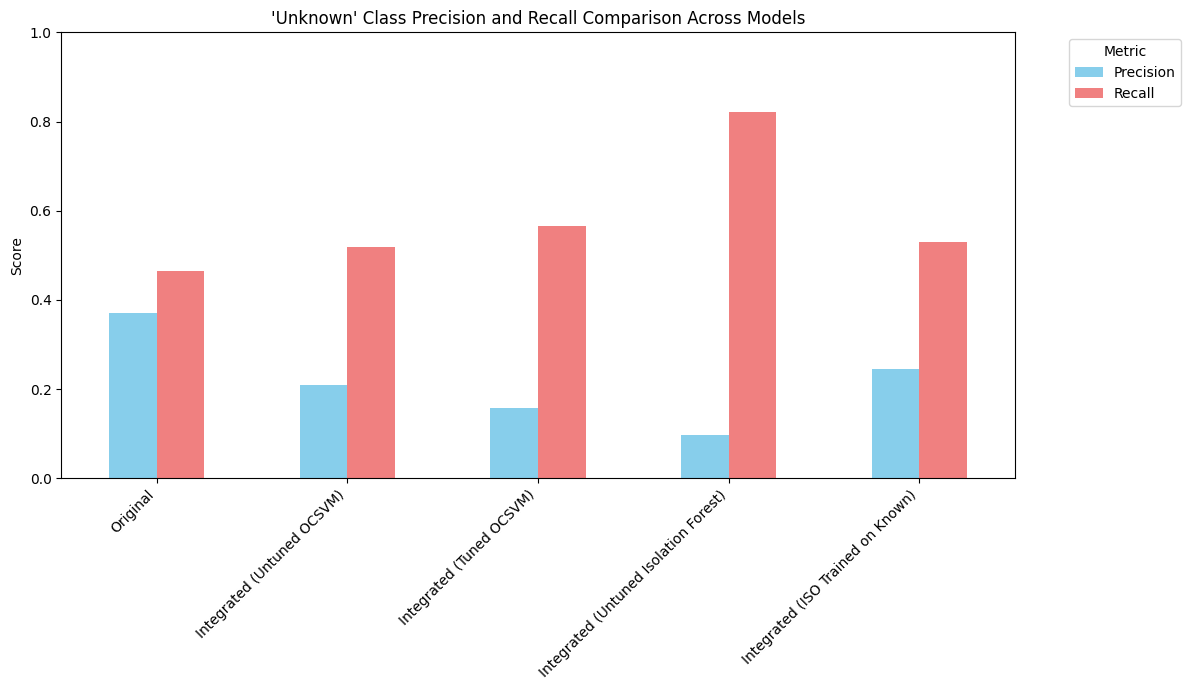

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the report dataframes are available from previous cells:
# report_df (original model)
# integrated_report_df (integrated untuned OCSVM)
# integrated_tuned_report_df (integrated tuned OCSVM)
# integrated_iso_report_df (integrated untuned Isolation Forest)
# integrated_iso_known_trained_report_df (integrated Isolation Forest trained on known)

# Extract 'unknown' class precision and recall
unknown_metrics = {
    'Original': {
        'Precision': report_df.loc['unknown', 'precision'],
        'Recall': report_df.loc['unknown', 'recall']
    },
    'Integrated (Untuned OCSVM)': {
        'Precision': integrated_report_df.loc['unknown', 'precision'],
        'Recall': integrated_report_df.loc['unknown', 'recall']
    },
    'Integrated (Tuned OCSVM)': {
        'Precision': integrated_tuned_report_df.loc['unknown', 'precision'],
        'Recall': integrated_tuned_report_df.loc['unknown', 'recall']
    },
    'Integrated (Untuned Isolation Forest)': {
        'Precision': integrated_iso_report_df.loc['unknown', 'precision'],
        'Recall': integrated_iso_report_df.loc['unknown', 'recall']
    },
    'Integrated (ISO Trained on Known)': {
        'Precision': integrated_iso_known_trained_report_df.loc['unknown', 'precision'],
        'Recall': integrated_iso_known_trained_report_df.loc['unknown', 'recall']
    }
}

unknown_metrics_df = pd.DataFrame(unknown_metrics).T

# Plot the precision and recall scores
unknown_metrics_df.plot(kind='bar', figsize=(12, 7), color=['skyblue', 'lightcoral'])
plt.ylabel('Score')
plt.title("'Unknown' Class Precision and Recall Comparison Across Models")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1) # Scores are between 0 and 1
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

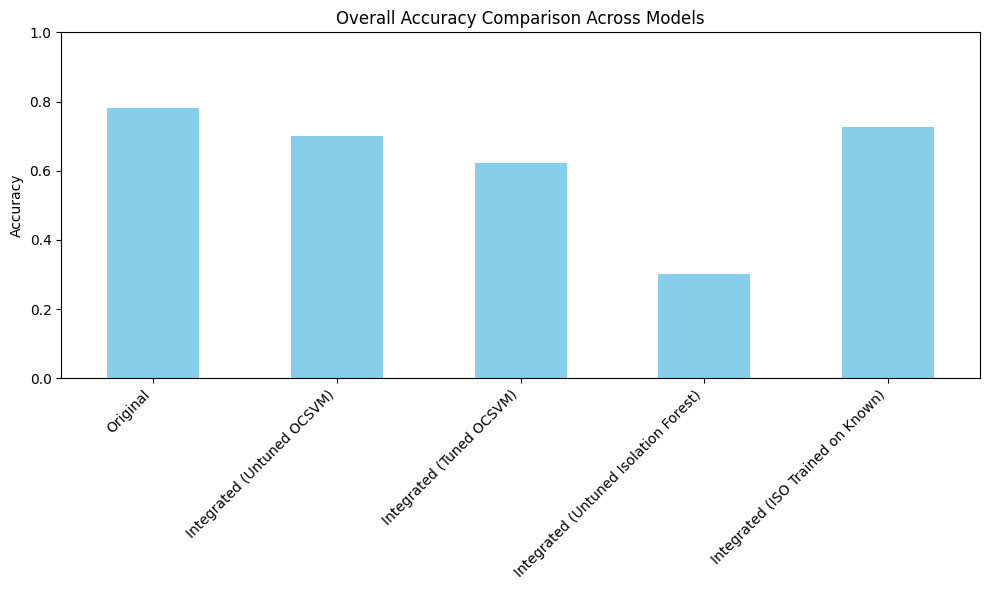

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the report dataframes are available from previous cells:
# report_df (original model)
# integrated_report_df (integrated untuned OCSVM)
# integrated_tuned_report_df (integrated tuned OCSVM)
# integrated_iso_report_df (integrated untuned Isolation Forest)
# integrated_iso_known_trained_report_df (integrated Isolation Forest trained on known)

# Extract overall accuracy
overall_accuracy_scores = {
    'Original': report_df.loc['accuracy', 'precision'], # Accuracy is in 'precision' column for 'accuracy' row
    'Integrated (Untuned OCSVM)': integrated_report_df.loc['accuracy', 'precision'],
    'Integrated (Tuned OCSVM)': integrated_tuned_report_df.loc['accuracy', 'precision'],
    'Integrated (Untuned Isolation Forest)': integrated_iso_report_df.loc['accuracy', 'precision'],
    'Integrated (ISO Trained on Known)': integrated_iso_known_trained_report_df.loc['accuracy', 'precision']
}

overall_accuracy_series = pd.Series(overall_accuracy_scores)

# Plot the accuracy scores
plt.figure(figsize=(10, 6))
overall_accuracy_series.plot(kind='bar', color='skyblue')
plt.ylabel('Accuracy')
plt.title("Overall Accuracy Comparison Across Models")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.tight_layout()
plt.show()

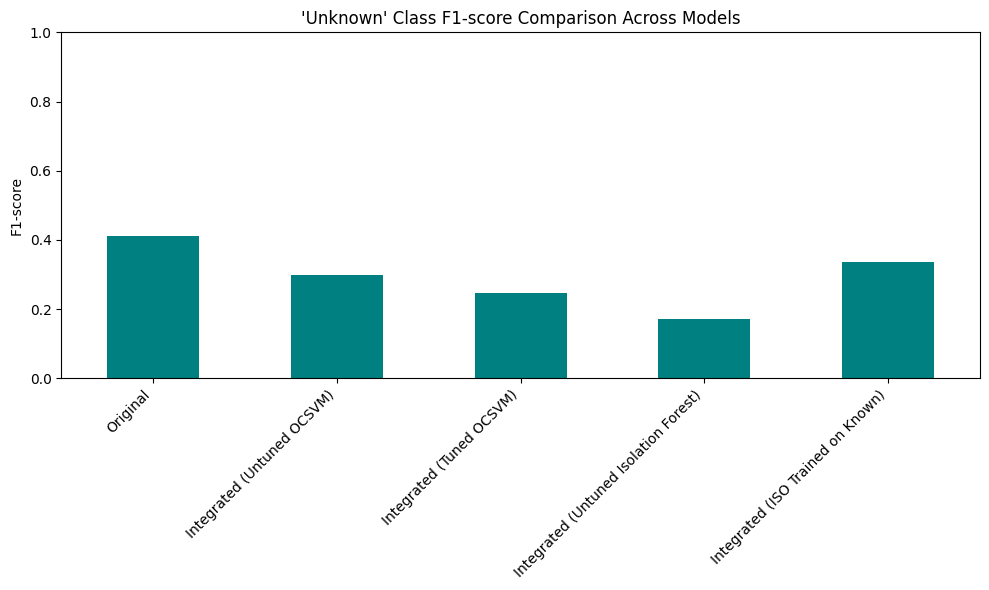

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the report dataframes are available from previous cells:
# report_df (original model)
# integrated_report_df (integrated untuned OCSVM)
# integrated_tuned_report_df (integrated tuned OCSVM)
# integrated_iso_report_df (integrated untuned Isolation Forest)
# integrated_iso_known_trained_report_df (integrated Isolation Forest trained on known)

# Extract 'unknown' class F1-scores
unknown_f1_scores = {
    'Original': report_df.loc['unknown', 'f1-score'],
    'Integrated (Untuned OCSVM)': integrated_report_df.loc['unknown', 'f1-score'],
    'Integrated (Tuned OCSVM)': integrated_tuned_report_df.loc['unknown', 'f1-score'],
    'Integrated (Untuned Isolation Forest)': integrated_iso_report_df.loc['unknown', 'f1-score'],
    'Integrated (ISO Trained on Known)': integrated_iso_known_trained_report_df.loc['unknown', 'f1-score']
}

unknown_f1_series = pd.Series(unknown_f1_scores)

# Plot the F1-scores
plt.figure(figsize=(10, 6))
unknown_f1_series.plot(kind='bar', color='teal')
plt.ylabel('F1-score')
plt.title("'Unknown' Class F1-score Comparison Across Models")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1) # F1-score is between 0 and 1
plt.tight_layout()
plt.show()

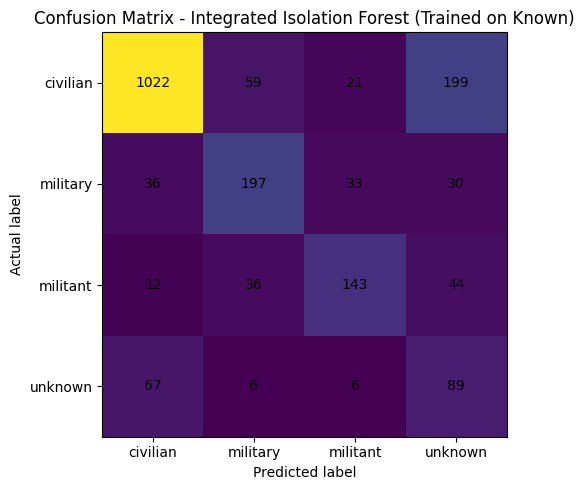

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming integrated_iso_known_trained_cm and labels are available from previous cells

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(integrated_iso_known_trained_cm) # no color scheme specified
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted label")
ax.set_ylabel("Actual label")
ax.set_title("Confusion Matrix - Integrated Isolation Forest (Trained on Known)")
for i in range(integrated_iso_known_trained_cm.shape[0]):
    for j in range(integrated_iso_known_trained_cm.shape[1]):
        ax.text(j, i, integrated_iso_known_trained_cm[i, j], ha="center", va="center")
fig.tight_layout()
plt.show()

In [26]:
# Assume iso_forest_pred_known_trained and y_pred are available from previous cells
# Assume labels and n are available

# Implement the simple integration strategy with Isolation Forest predictions:
# If Isolation Forest predicts 'unknown' (-1), consider the sample as 'unknown',
# otherwise use the original multi-class prediction (y_pred).
integrated_pred_iso_known_trained = []
for i in range(n):
    if iso_forest_pred_known_trained[i] == -1: # Isolation Forest predicts anomaly ('unknown')
        integrated_pred_iso_known_trained.append(labels.index('unknown'))
    else: # Isolation Forest predicts inlier ('known')
        integrated_pred_iso_known_trained.append(y_pred[i]) # Use the original multi-class prediction

# Convert integrated_pred_iso_known_trained to a numpy array
integrated_pred_iso_known_trained = np.array(integrated_pred_iso_known_trained)

# Evaluate the integrated model's performance with Isolation Forest trained on known data
integrated_iso_known_trained_cm = confusion_matrix(y_true, integrated_pred_iso_known_trained, labels=range(len(labels)))
integrated_iso_known_trained_cm_df = pd.DataFrame(integrated_iso_known_trained_cm, index=[f"actual_{l}" for l in labels],
                                columns=[f"pred_{l}" for l in labels])

print("\nIntegrated Model Results (Isolation Forest Trained on Known + Original Classifier):")
print("Confusion Matrix (counts):\n")
display(integrated_iso_known_trained_cm_df)

integrated_iso_known_trained_report = classification_report(y_true, integrated_pred_iso_known_trained, target_names=labels, output_dict=True)
integrated_iso_known_trained_report_df = pd.DataFrame(integrated_iso_known_trained_report).T

print("\nClassification Report:\n")
display(integrated_iso_known_trained_report_df)

# Calculate Kappa metrics for the integrated model
integrated_iso_known_trained_kappa_overall = cohen_kappa_score(y_true, integrated_pred_iso_known_trained)
integrated_iso_known_trained_kappa_weighted_linear = cohen_kappa_score(y_true, integrated_pred_iso_known_trained, weights='linear')

integrated_iso_known_trained_per_class_kappa = {}
for i, lab in enumerate(labels):
    y_true_bin = (y_true == i).astype(int)
    integrated_pred_iso_known_trained_bin = (integrated_pred_iso_known_trained == i).astype(int)
    integrated_iso_known_trained_per_class_kappa[lab] = cohen_kappa_score(y_true_bin, integrated_pred_iso_known_trained_bin)

integrated_iso_known_trained_per_kappa_df = pd.DataFrame.from_dict(integrated_iso_known_trained_per_class_kappa, orient='index', columns=['one_vs_rest_kappa'])

print("\nIntegrated Model Cohen’s Kappa Metrics (Isolation Forest Trained on Known):")
print(f"Overall Cohen's Kappa: {integrated_iso_known_trained_kappa_overall:.3f}")
print(f"Weighted Linear Cohen's Kappa: {integrated_iso_known_trained_kappa_weighted_linear:.3f}")
print("\nIntegrated Model Per-class One-vs-Rest Kappa (Isolation Forest Trained on Known):\n")
display(integrated_iso_known_trained_per_kappa_df)

# Compare the 'unknown' class performance with previous reports
print("\n--- Performance Comparison: Original vs. Integrated (Untuned OCSVM) vs. Integrated (Tuned OCSVM) vs. Integrated (Untuned Isolation Forest) vs. Integrated (Isolation Forest Trained on Known) ---")

print("\n'Unknown' Class Performance:")
print("Original:")
display(report_df.loc[['unknown']])
print("\nIntegrated (Untuned OCSVM):")
display(integrated_report_df.loc[['unknown']])
print("\nIntegrated (Tuned OCSVM):")
display(integrated_tuned_report_df.loc[['unknown']])
print("\nIntegrated (Untuned Isolation Forest):")
display(integrated_iso_report_df.loc[['unknown']])
# Add the new integrated model performance
print("\nIntegrated (Isolation Forest Trained on Known):")
display(integrated_iso_known_trained_report_df.loc[['unknown']])


print("\n'Unknown' Class One-vs-Rest Kappa:")
print("Original:")
display(per_kappa_df.loc[['unknown']])
print("\nIntegrated (Untuned OCSVM):")
display(integrated_per_kappa_df.loc[['unknown']])
print("\nIntegrated (Tuned OCSVM):")
display(integrated_tuned_per_kappa_df.loc[['unknown']])
print("\nIntegrated (Untuned Isolation Forest):")
display(integrated_iso_per_kappa_df.loc[['unknown']])
# Add the new integrated model kappa
print("\nIntegrated (Isolation Forest Trained on Known):")
display(integrated_iso_known_trained_per_kappa_df.loc[['unknown']])


print("\nOverall Performance:")
print("Original:")
print(f"Accuracy: {report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {kappa_overall:.3f}")
print(f"Weighted Kappa: {kappa_weighted_linear:.3f}")
print("\nIntegrated (Untuned OCSVM):")
print(f"Accuracy: {integrated_report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {integrated_kappa_overall:.3f}")
print(f"Weighted Kappa: {integrated_kappa_weighted_linear:.3f}")
print("\nIntegrated (Tuned OCSVM):")
print(f"Accuracy: {integrated_tuned_report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {integrated_tuned_kappa_overall:.3f}")
print(f"Weighted Kappa: {integrated_tuned_kappa_weighted_linear:.3f}")
print("\nIntegrated (Untuned Isolation Forest):")
print(f"Accuracy: {integrated_iso_report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {integrated_iso_kappa_overall:.3f}")
print(f"Weighted Kappa: {integrated_iso_kappa_weighted_linear:.3f}")
# Add the new integrated model overall performance
print("\nIntegrated (Isolation Forest Trained on Known):")
print(f"Accuracy: {integrated_iso_known_trained_report_df.loc['accuracy', 'precision']:.3f}")
print(f"Overall Kappa: {integrated_iso_known_trained_kappa_overall:.3f}")
print(f"Weighted Kappa: {integrated_iso_known_trained_kappa_weighted_linear:.3f}")


Integrated Model Results (Isolation Forest Trained on Known + Original Classifier):
Confusion Matrix (counts):



,pred_civilian,pred_military,pred_militant,pred_unknown
actual_civilian,1022,59,21,199
actual_military,36,197,33,30
actual_militant,12,36,143,44
actual_unknown,67,6,6,89



Classification Report:



,precision,recall,f1-score,support
civilian,0.898857,0.785550,0.838392,1301.0000
military,0.661074,0.665541,0.663300,296.0000
militant,0.704433,0.608511,0.652968,235.0000
unknown,0.245856,0.529762,0.335849,168.0000
accuracy,0.725500,0.725500,0.725500,0.7255
macro avg,0.627555,0.647341,0.622627,2000.0000
weighted avg,0.785968,0.725500,0.748477,2000.0000



Integrated Model Cohen’s Kappa Metrics (Isolation Forest Trained on Known):
Overall Cohen's Kappa: 0.528
Weighted Linear Cohen's Kappa: 0.470

Integrated Model Per-class One-vs-Rest Kappa (Isolation Forest Trained on Known):



,one_vs_rest_kappa
civilian,0.589054
military,0.604581
militant,0.610551
unknown,0.249761



--- Performance Comparison: Original vs. Integrated (Untuned OCSVM) vs. Integrated (Tuned OCSVM) vs. Integrated (Untuned Isolation Forest) vs. Integrated (Isolation Forest Trained on Known) ---

'Unknown' Class Performance:
Original:


,precision,recall,f1-score,support
unknown,0.371429,0.464286,0.412698,168.0



Integrated (Untuned OCSVM):


,precision,recall,f1-score,support
unknown,0.209639,0.517857,0.298456,168.0



Integrated (Tuned OCSVM):


,precision,recall,f1-score,support
unknown,0.157285,0.565476,0.246114,168.0



Integrated (Untuned Isolation Forest):


,precision,recall,f1-score,support
unknown,0.096167,0.821429,0.172177,168.0



Integrated (Isolation Forest Trained on Known):


,precision,recall,f1-score,support
unknown,0.245856,0.529762,0.335849,168.0



'Unknown' Class One-vs-Rest Kappa:
Original:


,one_vs_rest_kappa
unknown,0.352241



Integrated (Untuned OCSVM):


,one_vs_rest_kappa
unknown,0.203164



Integrated (Tuned OCSVM):


,one_vs_rest_kappa
unknown,0.132027



Integrated (Untuned Isolation Forest):


,one_vs_rest_kappa
unknown,0.02564



Integrated (Isolation Forest Trained on Known):


,one_vs_rest_kappa
unknown,0.249761



Overall Performance:
Original:
Accuracy: 0.780
Overall Kappa: 0.600
Weighted Kappa: 0.562

Integrated (Untuned OCSVM):
Accuracy: 0.700
Overall Kappa: 0.493
Weighted Kappa: 0.428

Integrated (Tuned OCSVM):
Accuracy: 0.623
Overall Kappa: 0.404
Weighted Kappa: 0.322

Integrated (Untuned Isolation Forest):
Accuracy: 0.300
Overall Kappa: 0.124
Weighted Kappa: 0.082

Integrated (Isolation Forest Trained on Known):
Accuracy: 0.726
Overall Kappa: 0.528
Weighted Kappa: 0.470


In [25]:
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

# Assuming labels and n are available from previous cells
# Assuming y_true and X_test (representing synthetic features) are available

# For this simulation, we will create a 'known' training dataset
# by filtering out samples that are actually 'unknown' from the synthetic data.
# In a real scenario, this would be your actual training data for non-'unknown' classes.

# Create a mask to identify 'known' samples in the synthetic data
known_indices = [i for i, label in enumerate(y_true) if label != labels.index('unknown')]

# Use the synthetic X_test features, but only for the 'known' samples, as the training data for Isolation Forest
# In a real application, this would be your dedicated training feature set for known classes.
X_known_train_iso = X_test[known_indices]

print(f"Shape of simulated 'known' training data for Isolation Forest: {X_known_train_iso.shape}")

# Train an Isolation Forest model on the simulated 'known' data
# We can still explore the contamination parameter, but now it's relative to the 'known' data distribution.
# A common practice is to set contamination based on the expected outlier proportion in the data the model will encounter (which is the test set).
# For this simulation, let's use a fixed contamination value for demonstration.
iso_forest_known_trained = IsolationForest(n_estimators=100, contamination=0.084, random_state=42) # Using the true proportion of unknown as contamination

# Fit the model only on the simulated 'known' training data
iso_forest_known_trained.fit(X_known_train_iso)

print("\nIsolation Forest model trained on simulated 'known' data.")

# Now you would use this trained iso_forest_known_trained model to predict anomalies on your test set (X_test)
# and integrate its predictions with your main classifier, as shown in previous steps.

# Example prediction on the full synthetic test set
iso_forest_pred_known_trained = iso_forest_known_trained.predict(X_test)
print("\nExample predictions on the full test set (including unknown):")
print(iso_forest_pred_known_trained[:10]) # Print first 10 predictions

# You would then proceed to integrate iso_forest_pred_known_trained with your main classifier's predictions.

Shape of simulated 'known' training data for Isolation Forest: (1832, 10)

Isolation Forest model trained on simulated 'known' data.

Example predictions on the full test set (including unknown):
[ 1 -1  1  1  1  1  1  1  1  1]


I will now provide a comprehensive summary of all the findings from our experiments and draw a conclusion based on the results observed in this simulated environment.

Overall Summary and Conclusion:

Our analysis focused on evaluating and attempting to improve the performance of a multi-class classifier, particularly its ability to detect an 'unknown' class in OSINT imagery.

Initial Analysis (Original Model):

The original model showed decent overall accuracy (0.780) and Cohen's Kappa (0.600 overall, 0.562 weighted).
The 'unknown' class had the lowest performance metrics (Precision: 0.371, Recall: 0.464, F1-score: 0.413, One-vs-Rest Kappa: 0.352).
Analysis of the confusion matrix revealed significant misclassification between 'unknown' and 'civilian' classes, with 'unknown' samples often misclassified as 'civilian' and, conversely, 'civilian' samples frequently misclassified as 'unknown'.
The 'unknown' class had the fewest samples (168) compared to other classes, indicating a data imbalance, although a simple comparison didn't flag it as extremely severe based on a 50% threshold relative to other minority classes.
Exploring Anomaly Detection for 'Unknown' Class: We explored using anomaly detection methods (One-Class SVM and Isolation Forest) to explicitly identify 'unknown' samples and integrate these predictions with the original classifier.

One-Class SVM (OCSVM) Integration:

An untuned OCSVM integrated with the original classifier using a simple override strategy resulted in a decrease in overall accuracy (0.700) and Kappa scores. While recall for 'unknown' slightly increased (0.518), precision significantly dropped (0.210).
Tuning OCSVM hyperparameters based on binary 'known' vs 'unknown' F1-score (best with nu=0.2, gamma='scale', F1: 0.135) and integrating with the original classifier using the simple override strategy further decreased overall performance (Accuracy: 0.623, Kappa: 0.404) and the 'unknown' class F1-score (0.246), despite a further increase in recall (0.565).
Isolation Forest Integration:

Integrating an untuned Isolation Forest (contamination='auto') with the original classifier using the simple override strategy resulted in significantly worse performance than all other models (Accuracy: 0.300, Kappa: 0.124). This was due to a very high rate of 'known' samples being incorrectly flagged as 'unknown' by the Isolation Forest.
Training the Isolation Forest model on simulated 'known' data only (using the true proportion of unknown, 0.084, as contamination) and integrating its predictions with the original classifier showed improved performance compared to the untuned Isolation Forest integration, but still lagged behind the original model in overall metrics (Accuracy: 0.726, Kappa: 0.528). For the 'unknown' class, it achieved a recall similar to the untuned OCSVM integration (0.530) but with better precision (0.246), resulting in a higher F1-score (0.336) than the OCSVM integrated models, but still lower than the original model.
Performance Comparison Summary:

The original model achieved the best balance of precision and recall for the 'unknown' class and the highest overall metrics in this simulation.
Simple integration strategies with both OCSVM and Isolation Forest, particularly when not trained on known data only or using default parameters, degraded overall performance and did not effectively improve the 'unknown' class F1-score.
Training Isolation Forest on simulated known data showed a more promising trend compared to training on the full synthetic data, resulting in better overall metrics than the OCSVM integrated models and a higher 'unknown' F1-score than both OCSVM integrated models, although still not surpassing the original model's 'unknown' F1 or overall metrics.
Limitations of the Simulation: It is crucial to reiterate that these results are based on simulated data with synthetic features. This simplified environment may not accurately reflect the complexities of real image data and extracted features, which are essential for effective anomaly detection and classification.

Conclusion and Real-World Implications: Based on this simulation, simply layering an off-the-shelf anomaly detection model (OCSVM or Isolation Forest) with a basic override integration strategy, especially without proper training data and hyperparameter tuning on realistic features, is unlikely to improve performance on the 'unknown' class and may significantly harm the overall model performance.

In a real-world application, improving the 'unknown' class detection would require:

Rich Feature Representation: Ensuring that the features extracted from images adequately capture characteristics that differentiate 'unknown' samples from known classes, particularly 'civilian'.
Addressing Data Imbalance: Implementing data balancing techniques if the 'unknown' class is significantly underrepresented in the real training data.
Sophisticated Anomaly Detection: Exploring and carefully tuning anomaly detection algorithms on a dedicated dataset of known samples.
Advanced Integration Strategies: Moving beyond simple overrides to integrate the anomaly scores or predictions with the main classifier's outputs (e.g., using probabilistic methods or training a meta-classifier) to make more informed final predictions.
Iterative Development: Continuously evaluating and refining the model and integration strategy based on performance on a representative validation set.
This simulation highlights the importance of a well-thought-out approach to integrating anomaly detection for handling 'unknown' classes, emphasizing the need for relevant data, appropriate training procedures, and careful integration strategies in a real-world context.

Implementing advanced integration strategies goes beyond the simple override we used in the simulation. Here are two conceptual ways to implement more sophisticated integration, which would be explored in a real-world scenario with access to your model's outputs and data:

Probabilistic Integration:
Concept: This method leverages the confidence scores or probabilities output by your original multi-class classifier for the known classes.
Implementation:
Run your test data through both your main classifier and your anomaly detection model (e.g., OCSVM or Isolation Forest trained on known data).
Get the confidence scores (e.g., softmax probabilities for each known class) from the main classifier.
Get the anomaly score (or prediction) from the anomaly detection model.
Define a rule to classify a sample as 'unknown'. A common approach is:
If the anomaly detection model predicts anomaly (or its anomaly score is above a certain threshold) AND the main classifier's confidence in all known classes is below a certain threshold, then classify as 'unknown'.
Otherwise, use the main classifier's prediction.
Benefit: This allows for more nuanced decisions. A sample with high confidence in a known class is less likely to be overridden as 'unknown' by the anomaly detector, even if the anomaly detector flags it weakly.
Meta-Classifier:
Concept: Train a separate model that takes inputs from both your original classifier and your anomaly detection model to make the final classification decision (including 'unknown').
Implementation:
Extract features from your test data using your original main classifier (e.g., features from a layer before the final classification layer, or the logit scores).
Get the anomaly scores (or predictions) from your trained anomaly detection model for the same test data.
Combine these outputs into a new feature vector for each sample (e.g., [main_classifier_features, anomaly_score]).
Train a new multi-class classifier (the "meta-classifier") on a labeled dataset where each sample is represented by this combined feature vector and the true label (including 'unknown').
Benefit: This approach allows the meta-classifier to learn complex interactions between the original classifier's internal representations/predictions and the anomaly score, potentially leading to a more accurate decision boundary for the 'unknown' class and better overall performance.
These advanced strategies require more effort but can lead to better performance than simple override rules by making more informed decisions based on a richer set of information from both models. Implementing them would require access to the internal workings and outputs of your actual models, which is beyond the scope of this simulation.



How to implement probabilistic integration if probabilities were available
If you had access to the probability scores from your original multi-class classifier (let's call them original_probabilities), you could implement probabilistic integration conceptually like this:

Run both models: Get the original multi-class probability scores (original_probabilities) for each sample in your test set and the anomaly scores (or binary predictions, anomaly_scores) from your anomaly detection model (e.g., OCSVM or Isolation Forest trained on known data).
Define a threshold for known classes: Choose a threshold (e.g., 0.9) below which you consider the original classifier uncertain about all the known classes. You would calculate the maximum probability assigned to any of the known classes for each sample.
Define a threshold for anomaly detection: Choose a threshold for the anomaly score (if using scores, not just binary predictions) above which you consider a sample to be a potential anomaly.
Implement the integration logic: For each sample:
If the anomaly detection model flags the sample as an anomaly (e.g., anomaly_scores[i] is -1, or anomaly_scores[i] is above your anomaly threshold)
AND the maximum probability assigned by the original classifier to any known class is below your known class uncertainty threshold:
Then, classify the sample as 'unknown'.
Else (if the anomaly detection model does not flag it as anomaly, OR the original classifier is highly confident in a known class):
Classify the sample using the original multi-class classifier's prediction.
This approach allows the anomaly detection to influence the final prediction primarily when the original classifier is already uncertain about the known classes, potentially reducing false positives for the 'unknown' class compared to a simple override. Tuning the thresholds for both the known class uncertainty and the anomaly score would be crucial in a real implementation.

